# Assignment 3 #

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized. The distances between nodes are calculated as Euclidean distances rounded mathematically to integer values. The distance matrix should be calculated just after reading an instance and then only the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow instances defined only by distance matrices. 

## Read the data ##

In [278]:
import pandas as pd
import numpy as np
from numpy.typing import ArrayLike, NDArray
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from math import sqrt
from typing import List, Optional, Tuple, Union 

In [279]:
# read data into dataframes
instances = {
    "A": pd.read_csv("data/TSPA.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "B": pd.read_csv("data/TSPB.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "C": pd.read_csv("data/TSPC.csv", sep=';', header=None, names=["x", "y", "cost"]),
    "D": pd.read_csv("data/TSPD.csv", sep=';', header=None, names=["x", "y", "cost"]),
}

In [3]:
def calculate_distance_matrix(df: pd.DataFrame) -> NDArray[np.int32]:
    """
    Calculate the distance matrix from the dataframe.
    The dataframe contains 'x' and 'y' columns for the coordinates.
    The distances are Euclidean, rounded to the nearest integer + the cost of the destination node.
    """
    coordinates = df[['x', 'y']].to_numpy()
    dist_matrix = np.zeros(shape=(len(df), len(df)))
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            dist_matrix[i, j] = round(sqrt((coordinates[i, 0] - coordinates[j, 0])**2 + (coordinates[i, 1] - coordinates[j, 1])**2))
    return dist_matrix

In [4]:
distances_matrices = {
    "A": calculate_distance_matrix(instances["A"]),
    "B": calculate_distance_matrix(instances["B"]),
    "C": calculate_distance_matrix(instances["C"]),
    "D": calculate_distance_matrix(instances["D"])
}

costs = {
    "A": instances["A"]["cost"].to_numpy(),
    "B": instances["B"]["cost"].to_numpy(),
    "C": instances["C"]["cost"].to_numpy(),
    "D": instances["D"]["cost"].to_numpy()
}

In [5]:
def visualize_selected_route(
    selected_nodes_indices: ArrayLike, 
    dataframe: pd.DataFrame,
    title: str) -> None:
    """
    Visualize the selected route returned by the algorithm, including the cost of each node represented by a colormap.

    Parameters:
    selected_nodes_indices (list): Indices of the selected nodes in the route.
    dataframe (DataFrame): DataFrame containing 'x', 'y', and 'cost' columns for each node.
    """
    x = dataframe["x"].to_numpy()
    y = dataframe["y"].to_numpy()
    costs = dataframe["cost"].to_numpy()

    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(costs), vmax=max(costs))

    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(x, y, c=costs, cmap=cmap, norm=norm, s=100)
    plt.colorbar(scatter, label='Node Cost')

    for i, node in enumerate(selected_nodes_indices):
        start_node = selected_nodes_indices[i]
        end_node = selected_nodes_indices[(i + 1) % len(selected_nodes_indices)]
        plt.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-', lw=1)

    plt.title(title, fontsize=18)
    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.grid(True)
    plt.show()

In [6]:
def objective_function(solution: list[int], dist_matrix: list[list[int]], costs: list[int]) -> int:
    total_score = 0
    n = len(solution)
    for x in range(n):
        total_score += dist_matrix[solution[x - 1]][solution[x]]
        total_score += costs[solution[x]]
    return total_score

In [7]:
# A function that generates a random solution
def generate_random_solution(n: int) -> list[int]:
    """
    Generate a random solution for a given number of nodes.

    :param n: The number of nodes.
    :return: A list of nodes representing the solution.
    """
    return random.sample(range(0, n * 2), n)

In [526]:
def two_edges_exchange(current_solution: list[int], 
                       current_distance: float, 
                       distance_matrix: list[list[int]]):
    """
    Generate new solutions by exchanging two edges in the current solution.

    :param current_solution: List of nodes in the current solution.
    :param current_score: The score of the current solution.
    :param distance_matrix: 2D list representing the distances between nodes.
    :return: A list of tuples where each tuple contains a new solution and its score.
    """
    n = len(current_solution)
    new_solutions = []

    for i in range(n - 2):
        for j in range(i + 2, n):
            # Create a new solution by reversing the order of nodes between i and j
            new_solution = current_solution[:i + 1] + current_solution[i + 1:j + 1][::-1] + current_solution[j + 1:]

            score_delta = (
                -distance_matrix[current_solution[i]][current_solution[i + 1]]
                -distance_matrix[current_solution[j]][current_solution[(j + 1) % n]]
                +distance_matrix[current_solution[i]][current_solution[j]]
                +distance_matrix[current_solution[i + 1]][current_solution[(j + 1) % n]]
            )
            new_score = current_distance + score_delta

            new_solutions.append((new_solution, 
                                  new_score))
    
    return new_solutions

In [527]:
def two_edges_exchange_advanced(current_solution: list[int], 
                                current_distance: float, 
                                distance_matrix: list[list[int]],
                                start_index: int = 0,
                                direction: str = "right"):
    """
    Generate a new solution by exchanging two edges in the current solution,
    starting from a given index and moving in the specified direction.

    :param current_solution: List of nodes in the current solution.
    :param current_distance: The score of the current solution.
    :param distance_matrix: 2D list representing the distances between nodes.
    :param start_index: The index from which to start searching for a better solution.
    :param direction: The direction in which to search for a better solution ("right" or "left").
    :return: A tuple containing the new solution and its score if it's better,
             otherwise the original solution and score.
    """
    n = len(current_solution)

    # Define the order of iteration based on the direction
    if direction == "right":
        range_i = range(n - 2)
        range_j = lambda i: range(i + 2, n)
    else:  # direction == "left"
        range_i = range(n - 3, -1, -1)
        range_j = lambda i: range(n - 1, i + 1, -1)

    # Convert the linear start index to a pair of indices (i, j)
    count = 0
    for i in range_i:
        for j in range_j(i):
            if count >= start_index:
                # Perform the two-edges exchange from this point
                new_solution = (current_solution[:i + 1] 
                                + current_solution[i + 1:j + 1][::-1] 
                                + current_solution[j + 1:])

                score_delta = (
                    -distance_matrix[current_solution[i]][current_solution[i + 1]]
                    -distance_matrix[current_solution[j]][current_solution[(j + 1) % n]]
                    +distance_matrix[current_solution[i]][current_solution[j]]
                    +distance_matrix[current_solution[i + 1]][current_solution[(j + 1) % n]]
                )
                new_score = current_distance + score_delta

                if new_score < current_distance:
                    return new_solution, new_score

            count += 1  # Increment the counter after checking the condition

    return None


In [528]:
def two_nodes_exchange(current_solution, score, distance_matrix, start_index=0, direction='right'):
    n = len(current_solution)
    total_moves = n * (n - 1) // 2  # Total number of possible swaps

    index_pairs = [(x, y) for x in range(n) for y in range(x+1, n)]
    # Adjust the indices list based on the direction
    if direction == 'left':
        index_pairs = index_pairs[::-1]
        start_index = total_moves - start_index - 1 

    for count, (i, j) in enumerate(index_pairs[start_index:], start=start_index):
        temp = current_solution[:]
        temp_score = score

        if i == 0 and j == n - 1:  # special case: first and last nodes
            score_delta = (
                -distance_matrix[current_solution[j]][current_solution[0]]
                -distance_matrix[current_solution[j-1]][current_solution[j]]
                -distance_matrix[current_solution[0]][current_solution[1]]
                +distance_matrix[current_solution[j]][current_solution[1]]
                +distance_matrix[current_solution[j-1]][current_solution[0]]
                +distance_matrix[current_solution[0]][current_solution[j]]
            )
        elif j == i + 1:  # adjacent nodes case
            score_delta = (
                -distance_matrix[current_solution[i - 1]][current_solution[i]]
                -distance_matrix[current_solution[j]][current_solution[(j + 1) % n]]
                +distance_matrix[current_solution[i - 1]][current_solution[j]]
                +distance_matrix[current_solution[i]][current_solution[(j + 1) % n]]
            )
        else:  # non-adjacent nodes case
            score_delta = (
                -distance_matrix[current_solution[i - 1]][current_solution[i]]
                -distance_matrix[current_solution[j - 1]][current_solution[j]]
                +distance_matrix[current_solution[i - 1]][current_solution[j]]
                +distance_matrix[current_solution[j - 1]][current_solution[i]]
                -distance_matrix[current_solution[i]][current_solution[(i + 1) % n]]
                -distance_matrix[current_solution[j]][current_solution[(j + 1) % n]]
                +distance_matrix[current_solution[i]][current_solution[(j + 1) % n]]
                +distance_matrix[current_solution[j]][current_solution[(i + 1) % n]]
            )

        temp[i], temp[j] = temp[j], temp[i]
        temp_score += score_delta
        # If the new score is better, return the new solution immediately
        if temp_score < score:
            return temp, temp_score
    # If no improvement is found, return None
    return None, None

In [529]:
random_solution = generate_random_solution(7)
score = objective_function(random_solution, distances_matrices["A"], costs["A"])
print(f"Random solution: {random_solution}")
print(f"Score: {score}")

Random solution: [8, 2, 3, 4, 9, 13, 12]
Score: 16104.0


In [530]:
two_nodes_exchange(random_solution, score, distances_matrices["A"], 1, "left")

(None, None)

In [531]:
def inter_route_exchange_simple(selected, unselected, score, distance_matrix, costs):
    new_solutions = []

    # Assume node indices are 0-based for distance_matrix
    for selected_node in selected:
        for new_node in unselected:
            new_solution = selected.copy()
            replaced_node_index = selected.index(selected_node)
            
            # Assuming 'selected' and 'unselected' contain 0-based indices already
            new_solution[replaced_node_index] = new_node

            prev_node_index = (replaced_node_index - 1) % len(selected)
            next_node_index = (replaced_node_index + 1) % len(selected)

            # Calculate score_delta considering 0-based indices for distance_matrix
            score_delta = (
                -distance_matrix[selected[prev_node_index]][selected_node]
                -distance_matrix[selected_node][selected[next_node_index]]
                +distance_matrix[selected[prev_node_index]][new_node]
                +distance_matrix[new_node][selected[next_node_index]]
                -costs[selected_node]
                +costs[new_node]
            )
            new_score = score + score_delta

            new_solutions.append((new_solution, new_score))

    return new_solutions


In [532]:
def inter_route_exchange(current_solution, unselected_nodes, distance_matrix, costs, start_index=0, direction="right"):
    n_selected = len(current_solution)
    n_unselected = len(unselected_nodes)
    current_score = objective_function(current_solution, distance_matrix, costs)
    # Create all possible combinations of selected and unselected nodes
    all_combinations = [(i, j) for i in range(n_selected) for j in range(n_unselected)]
    if direction == "left":
        all_combinations = all_combinations[::-1]
    for i, j in all_combinations[start_index:]:
        selected_node = current_solution[i]
        new_node = unselected_nodes[j]
        new_solution = current_solution.copy()
        new_solution[i] = new_node
        prev_node_index = (i - 1) % n_selected
        next_node_index = (i + 1) % n_selected
        score_delta = (
            -distance_matrix[current_solution[prev_node_index]][selected_node]
            -distance_matrix[selected_node][current_solution[next_node_index]]
            +distance_matrix[current_solution[prev_node_index]][new_node]
            +distance_matrix[new_node][current_solution[next_node_index]]
            -costs[selected_node]
            +costs[new_node]
        )
        new_score = current_score + score_delta
        if new_score < current_score:
            # remove from unselected nodes the new inserted ine
            unselected_nodes.remove(new_node)
            # add to unselected the node that has been dropped
            unselected_nodes.append(selected_node)
            return new_solution, new_score
    # If no better solution is found, return None
    return None, None

In [533]:
print(f"Random solution: {random_solution}")
print(f"Score: {score}")

Random solution: [8, 2, 3, 4, 9, 13, 12]
Score: 16104.0


In [534]:
inter_route_exchange_simple(random_solution, [2,3,6], score, distances_matrices["A"], costs["A"]) 

[([2, 2, 3, 4, 9, 13, 12], 16527.0),
 ([3, 2, 3, 4, 9, 13, 12], 19021.0),
 ([6, 2, 3, 4, 9, 13, 12], 15748.0),
 ([8, 2, 3, 4, 9, 13, 12], 16104.0),
 ([8, 3, 3, 4, 9, 13, 12], 16569.0),
 ([8, 6, 3, 4, 9, 13, 12], 15571.0),
 ([8, 2, 2, 4, 9, 13, 12], 13405.0),
 ([8, 2, 3, 4, 9, 13, 12], 16104.0),
 ([8, 2, 6, 4, 9, 13, 12], 15404.0),
 ([8, 2, 3, 2, 9, 13, 12], 17408.0),
 ([8, 2, 3, 3, 9, 13, 12], 17859.0),
 ([8, 2, 3, 6, 9, 13, 12], 17709.0),
 ([8, 2, 3, 4, 2, 13, 12], 15901.0),
 ([8, 2, 3, 4, 3, 13, 12], 18585.0),
 ([8, 2, 3, 4, 6, 13, 12], 16247.0),
 ([8, 2, 3, 4, 9, 2, 12], 16174.0),
 ([8, 2, 3, 4, 9, 3, 12], 18595.0),
 ([8, 2, 3, 4, 9, 6, 12], 14227.0),
 ([8, 2, 3, 4, 9, 13, 2], 18108.0),
 ([8, 2, 3, 4, 9, 13, 3], 20788.0),
 ([8, 2, 3, 4, 9, 13, 6], 16454.0)]

In [535]:
inter_route_exchange(random_solution, [2,3,6], distances_matrices["A"], costs["A"], start_index=3, direction="left")

([8, 2, 3, 4, 9, 6, 12], 14227.0)

# Repository for Local Search solution finder #

In [173]:
from abc import ABC, abstractmethod
from typing import Union, Optional


class LocalSearch(ABC):
    """
    Abstract class for local search algorithms.
    """
    def __init__(self, 
                 initial_solution: list[int], 
                 distance_matrix: list[list[int]], 
                 costs: list[int]) -> None:
        """
        :param initial_solution: The initial solution.
        :param initial_score: The score of the initial solution.
        :param distance_matrix: 2D list representing the distances between nodes.
        """
        self.initial_solution = initial_solution
        self.initial_score = objective_function(initial_solution, distance_matrix, costs)
        self.distance_matrix = distance_matrix
        self.costs = costs
        
        self.all_nodes = list(range(100*2))
        self.unselected_nodes = [node for node in self.all_nodes if node not in self.initial_solution]
        
        self.current_solution: list[int] = initial_solution
        self.current_score = self.initial_score
        
        self.moves = {
            "intra-two-edges-exchange": self.two_edges_exchange,
            "intra-two-nodes-exchange": self.two_nodes_exchange,
            "inter-route-exchange": self.inter_route_exchange
        }
        
        self.moves_utils = {
            "intra-two-edges-exchange": self.get_utils_intra_two_edges_exchange,
            "intra-two-nodes-exchange": self.get_utils_intra_two_nodes_exchange,
            "inter-route-exchange": self.get_utils_inter_route_exchange
        }
        
        
    @abstractmethod
    def get_utils_intra_two_edges_exchange(self):
        raise NotImplementedError
    
    @abstractmethod
    def get_utils_intra_two_nodes_exchange(self):
        raise NotImplementedError
    
    @abstractmethod
    def get_utils_inter_route_exchange(self):
        raise NotImplementedError

    # two method for intra moves
    @abstractmethod
    def two_edges_exchange(self, start_index: int = 0, direction: str = "right") -> Union[tuple[list[int], int], None]:
        """This method should return a new solution and its score if a better solution is found, otherwise None.
        For a greedy algorithm, the first better solution found should be returned. For a steepest local search,
        the best solution among all possible solutions should be returned, if there is no better solution, just
        return None. For a steepest local search, both neighborhood moves will return one solution, then we will
        take the better one among these two solutions.

        Parameters
        ----------
        current_solution : list[int]
        current_distance : int
        distance_matrix : list[list[int]]

        Returns
        -------
        tuple[list[int], int] | None
            A single better solution founded by the algorithm, or None if no better solution is found.
        """
        raise NotImplementedError
    
    @abstractmethod
    def two_nodes_exchange(self, start_index=0, direction='right') -> Union[tuple[list[int], int] , None]:
        raise NotImplementedError
    
    # one method for inter move
    @abstractmethod
    def inter_route_exchange(self, start_index=0, direction="right") -> Union[tuple[list[int], int] , None]:
        raise NotImplementedError
    
    @abstractmethod
    def run(self, *args, **kwargs) -> None:
        """
        Run the algorithm.
        """
        pass

# Greedy Local Search #

In [174]:

class GreedyLocalSearch(LocalSearch):
    def __init__(self, 
                 initial_solution: list[int], 
                 distance_matrix: list[list[int]], 
                 costs: list[int]) -> None:
        super().__init__(initial_solution, distance_matrix, costs)
        
        self.moves_probs = [0.5, 0.5]
        
        self.moves_sizes = {
            "intra-two-edges-exchange": len(self.current_solution) * (len(self.current_solution) - 3) // 2,
            "intra-two-nodes-exchange": len(self.current_solution) * (len(self.current_solution) - 1) // 2,
            "inter-route-exchange": len(self.current_solution) * len(self.unselected_nodes)
        }
        
    def get_utils_intra_two_nodes_exchange(self):
        n = len(self.current_solution)
        num_solutions = n*(n-1)/2
        start_index = random.randint(0, num_solutions-1)
        if start_index < num_solutions/2:
            direction = 'right' 
        else:   
            direction = 'left'
        return start_index, direction
    
    def get_utils_intra_two_edges_exchange(self):
        n = len(self.current_solution)
        num_solutions = n*(n-3)/2
        start_index = random.randint(0, int((num_solutions-1)/2))
        direction = random.choice(['right', 'left'])
        return start_index, direction
    
    def get_utils_inter_route_exchange(self):
        n_selected = len(self.current_solution)
        n_unselected = len(self.unselected_nodes)
        num_solutions = n_selected*n_unselected
        start_index = random.randint(0, int((num_solutions-1)/2))
        direction = random.choice(['right', 'left'])
        return start_index, direction
        
        
    def two_edges_exchange(self,
                            start_index: int = 0,
                            direction: str = "right"):
        """
        Generate a new solution by exchanging two edges in the current solution,
        starting from a given index and moving in the specified direction.

        :param current_solution: List of nodes in the current solution.
        :param current_distance: The score of the current solution.
        :param distance_matrix: 2D list representing the distances between nodes.
        :param start_index: The index from which to start searching for a better solution.
        :param direction: The direction in which to search for a better solution ("right" or "left").
        :return: A tuple containing the new solution and its score if it's better,
                otherwise the original solution and score.
        """
        n = len(self.current_solution)

        if direction == "right":
            range_i = range(n - 2)
            range_j = lambda i: range(i + 2, n)
        else:  # direction == "left"
            range_i = range(n - 3, -1, -1)
            range_j = lambda i: range(n - 1, i + 1, -1)
        count = 0
        for i in range_i:
            for j in range_j(i):
                if count >= start_index:
                    new_solution = (self.current_solution[:i + 1] 
                                    + self.current_solution[i + 1:j + 1][::-1] 
                                    + self.current_solution[j + 1:])

                    score_delta = (
                        -self.distance_matrix[self.current_solution[i]][self.current_solution[i + 1]]
                        -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                        +self.distance_matrix[self.current_solution[i]][self.current_solution[j]]
                        +self.distance_matrix[self.current_solution[i + 1]][self.current_solution[(j + 1) % n]]
                    )
                    new_score = self.current_score + score_delta

                    if new_score < self.current_score:
                        return new_solution, new_score

                count += 1  # Increment the counter after checking the condition

        return None, None
    
    def two_nodes_exchange(self, start_index=0, direction='right'):
        n = len(self.current_solution)
        total_moves = n * (n - 1) // 2  # Total number of possible swaps

        index_pairs = [(x, y) for x in range(n) for y in range(x+1, n)]
        # Adjust the indices list based on the direction
        if direction == 'left':
            index_pairs = index_pairs[::-1]
            start_index = total_moves - start_index - 1 

        for count, (i, j) in enumerate(index_pairs[start_index:], start=start_index):
            temp = self.current_solution[:]
            temp_score = self.current_score

            if i == 0 and j == n - 1:  # special case: first and last nodes
                score_delta = (
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[0]]
                    -self.distance_matrix[self.current_solution[j-1]][self.current_solution[j]]
                    -self.distance_matrix[self.current_solution[0]][self.current_solution[1]]
                    +self.distance_matrix[self.current_solution[j]][self.current_solution[1]]
                    +self.distance_matrix[self.current_solution[j-1]][self.current_solution[0]]
                    +self.distance_matrix[self.current_solution[0]][self.current_solution[j]]
                )
            elif j == i + 1:  # adjacent nodes case
                score_delta = (
                    -self.distance_matrix[self.current_solution[i - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[i - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[i]][self.current_solution[(j + 1) % n]]
                )
            else:  # non-adjacent nodes case
                score_delta = (
                    -self.distance_matrix[self.current_solution[i - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[j - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[i - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[j - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[i]][self.current_solution[(i + 1) % n]]
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[i]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[j]][self.current_solution[(i + 1) % n]]
                )

            temp[i], temp[j] = temp[j], temp[i]
            temp_score += score_delta
            # If the new score is better, return the new solution immediately
            if temp_score < self.current_score:
                return temp, temp_score
        # If no improvement is found, return None
        return None, None
    
    
    def inter_route_exchange(self, start_index=0, direction="right"):
        n_selected = len(self.current_solution)
        n_unselected = len(self.unselected_nodes)
        
        # Create all possible combinations of selected and unselected nodes
        all_combinations = [(i, j) for i in range(n_selected) for j in range(n_unselected)]
        if direction == "left":
            all_combinations = all_combinations[::-1]
        for i, j in all_combinations[start_index:]:
            selected_node = self.current_solution[i]
            new_node = self.unselected_nodes[j]
            new_solution = self.current_solution.copy()
            new_solution[i] = new_node
            prev_node_index = (i - 1) % n_selected
            next_node_index = (i + 1) % n_selected
            score_delta = (
                -self.distance_matrix[self.current_solution[prev_node_index]][selected_node]
                -self.distance_matrix[selected_node][self.current_solution[next_node_index]]
                +self.distance_matrix[self.current_solution[prev_node_index]][new_node]
                +self.distance_matrix[new_node][self.current_solution[next_node_index]]
                -self.costs[selected_node]
                +self.costs[new_node]
            )
            new_score = self.current_score + score_delta
            if new_score < self.current_score:
                # remove from unselected nodes the new inserted ine
                self.unselected_nodes.remove(new_node)
                # add to unselected the node that has been dropped
                self.unselected_nodes.append(selected_node)
                # print(self.unselected_nodes)
                return new_solution, new_score
        # If no better solution is found, return None
        return None, None
    
    def run(self, 
            start_solution: Optional[List[int]] ,
            moves: list[str],
            moves_prob: tuple[int, int] = (0.5, 0.5),
            show_progress: bool = True) -> tuple[list[int], int]:
        if not set(moves).issubset(self.moves.keys()):
            raise ValueError("Invalid moves list")
        if len(moves_prob) != len(moves):
            raise ValueError("Invalid moves probability list")
        if len(moves) != 2:
            raise ValueError("Only two moves are supported")
        
        self.moves_probs = moves_prob
        if start_solution is not None:
            self.current_solution = start_solution
            
            self.current_score = objective_function(start_solution, self.distance_matrix, self.costs)    
            
        progress = True
        epoch_counter = 0
        method_counter = {
            "intra-two-edges-exchange": 0,
            "intra-two-nodes-exchange": 0,
            "inter-route-exchange": 0   
        }
        while progress:
            chosen_move = np.random.choice(moves, p=moves_prob) # primary move
            start_index, direction = self.moves_utils[chosen_move]()
            new_solution, new_score = self.moves[chosen_move](start_index=start_index, direction=direction)
            if new_solution is not None: # if there is improvement, replace the solution
                self.current_solution = new_solution
                self.current_score = new_score
                # print(f"New best solution found: {self.current_score} by method {chosen_move} at epoch {epoch_counter}")
            else: # if there is no improvement, we try the same method but with different direction
                if chosen_move == "intra-two-nodes-exchange": # this method is the only one that should start from the same position but with different direction
                    direction = "left" if direction == "right" else "right"
                else:
                    direction = "left" if direction == "right" else "right"
                    start_index = self.moves_sizes[chosen_move] - start_index # other two moves behaves differently when changing direction
                new_solution, new_score = self.moves[chosen_move](start_index=start_index, direction=direction)
                if new_solution is not None:
                    self.current_solution = new_solution
                    self.current_score = new_score
                    # print(f"New best solution found: {self.current_score} by method {chosen_move} at epoch {epoch_counter}")
                    
                else: # now the second move
                    second_move = moves[1 - moves.index(chosen_move)]
                    start_index, direction = self.moves_utils[second_move]()
                    new_solution, new_score = self.moves[second_move](start_index=start_index, direction=direction)
                    if new_solution is not None:
                        self.current_solution = new_solution
                        self.current_score = new_score
                        # print(f"New best solution found: {self.current_score} by method {chosen_move} at epoch {epoch_counter}")
                        
                    else:
                        if second_move == "intra-two-nodes-exchange": # this method is the only one that should start from the same position but with different direction
                            direction = "left" if direction == "right" else "right"
                        else:
                            direction = "left" if direction == "right" else "right"
                            start_index = self.moves_sizes[second_move] - start_index
                        new_solution, new_score = self.moves[second_move](start_index=start_index, direction=direction)
                        if new_solution is not None:
                            self.current_solution = new_solution
                            self.current_score = new_score
                            # print(f"New best solution found: {self.current_score} by method {chosen_move} at epoch {epoch_counter}")
                        else:
                            progress = False
            epoch_counter += 1
            method_counter[chosen_move] += 1
            if epoch_counter % 50 == 0 and show_progress:
                print(f"Epoch: {epoch_counter}, Score: {self.current_score}, Method counter: {method_counter}")
        return self.current_solution, self.current_score, epoch_counter

# Steepest Local Search #

In [175]:
def check_overlap(list1, list2):
    # Use set intersection to find common elements
    common_elements = set(list1) & set(list2)
    if common_elements:
        raise ValueError(f"Error: The following elements are present in both lists: {common_elements}")

In [176]:
def check_for_duplicates(lst, name: str):
    if len(lst) != len(set(lst)):
        raise ValueError(f"Duplicates found in the {name}. {lst}")

In [182]:
class SteepestLocalSearch(LocalSearch):
    def __init__(self, 
                 initial_solution: list[int], 
                 distance_matrix: list[list[int]], 
                 costs: list[int]) -> None:
        super().__init__(initial_solution, distance_matrix, costs)
        
    def get_utils_intra_two_nodes_exchange(self):
        n = len(self.current_solution)
        num_solutions = n*(n-1)/2
        start_index = random.randint(0, num_solutions-1)
        if start_index < num_solutions/2:
            direction = 'right' 
        else:   
            direction = 'left'
        return start_index, direction
    
    def get_utils_intra_two_edges_exchange(self):
        n = len(self.current_solution)
        num_solutions = n*(n-3)/2
        start_index = random.randint(0, int((num_solutions-1)/2))
        direction = random.choice(['right', 'left'])
        return start_index, direction
    
    def get_utils_inter_route_exchange(self):
        n_selected = len(self.current_solution)
        n_unselected = len(self.unselected_nodes)
        num_solutions = n_selected*n_unselected
        start_index = random.randint(0, int((num_solutions-1)/2))
        direction = random.choice(['right', 'left'])
        return start_index, direction
        
    def two_edges_exchange(self,
                            start_index: int = 0,
                            direction: str = "right"):
        """
        Generate a new solution by exchanging two edges in the current solution,
        starting from a given index and moving in the specified direction.

        :param current_solution: List of nodes in the current solution.
        :param current_distance: The score of the current solution.
        :param distance_matrix: 2D list representing the distances between nodes.
        :param start_index: The index from which to start searching for a better solution.
        :param direction: The direction in which to search for a better solution ("right" or "left").
        :return: A tuple containing the new solution and its score if it's better,
                otherwise the original solution and score.
        """
        n = len(self.current_solution)

        if direction == "right":
            range_i = range(n - 2)
            range_j = lambda i: range(i + 2, n)
        else:  # direction == "left"
            range_i = range(n - 3, -1, -1)
            range_j = lambda i: range(n - 1, i + 1, -1)
        count = 0
        method_best_score = float("inf")
        method_best_solution = None
        for i in range_i:
            for j in range_j(i):
                if count >= start_index:
                    new_solution = (self.current_solution[:i + 1] 
                                    + self.current_solution[i + 1:j + 1][::-1] 
                                    + self.current_solution[j + 1:])

                    score_delta = (
                        -self.distance_matrix[self.current_solution[i]][self.current_solution[i + 1]]
                        -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                        +self.distance_matrix[self.current_solution[i]][self.current_solution[j]]
                        +self.distance_matrix[self.current_solution[i + 1]][self.current_solution[(j + 1) % n]]
                    )
                    new_score = self.current_score + score_delta

                    if new_score < method_best_score:
                        method_best_score = new_score
                        method_best_solution = new_solution

                count += 1  # Increment the counter after checking the condition
        return method_best_solution, method_best_score, "two-edges-exchange"
    
    def two_nodes_exchange(self, start_index=0, direction='right'):
        n = len(self.current_solution)
        total_moves = n * (n - 1) // 2  # Total number of possible swaps

        index_pairs = [(x, y) for x in range(n) for y in range(x+1, n)]
        # Adjust the indices list based on the direction
        if direction == 'left':
            index_pairs = index_pairs[::-1]
            start_index = total_moves - start_index - 1 
        method_best_score = float("inf")
        method_best_solution = None
        for count, (i, j) in enumerate(index_pairs[start_index:], start=start_index):
            temp = self.current_solution[:]
            temp_score = self.current_score

            if i == 0 and j == n - 1:  # special case: first and last nodes
                score_delta = (
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[0]]
                    -self.distance_matrix[self.current_solution[j-1]][self.current_solution[j]]
                    -self.distance_matrix[self.current_solution[0]][self.current_solution[1]]
                    +self.distance_matrix[self.current_solution[j]][self.current_solution[1]]
                    +self.distance_matrix[self.current_solution[j-1]][self.current_solution[0]]
                    +self.distance_matrix[self.current_solution[0]][self.current_solution[j]]
                )
            elif j == i + 1:  # adjacent nodes case
                score_delta = (
                    -self.distance_matrix[self.current_solution[i - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[i - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[i]][self.current_solution[(j + 1) % n]]
                )
            else:  # non-adjacent nodes case
                score_delta = (
                    -self.distance_matrix[self.current_solution[i - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[j - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[i - 1]][self.current_solution[j]]
                    +self.distance_matrix[self.current_solution[j - 1]][self.current_solution[i]]
                    -self.distance_matrix[self.current_solution[i]][self.current_solution[(i + 1) % n]]
                    -self.distance_matrix[self.current_solution[j]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[i]][self.current_solution[(j + 1) % n]]
                    +self.distance_matrix[self.current_solution[j]][self.current_solution[(i + 1) % n]]
                )

            temp[i], temp[j] = temp[j], temp[i]
            temp_score += score_delta
            # If the new score is better, return the new solution immediately
            if temp_score < method_best_score:
                method_best_score = temp_score
                method_best_solution = temp
        return method_best_solution, method_best_score, "two-nodes-exchange"
    
    
    def inter_route_exchange(self, start_index=0, direction="right"):
        n_selected = len(self.current_solution)
        n_unselected = len(self.unselected_nodes)
        
        # Create all possible combinations of selected and unselected nodes
        all_combinations = [(i, j) for i in range(n_selected) for j in range(n_unselected)]
        if direction == "left":
            all_combinations = all_combinations[::-1]
        all_scores = []
        method_best_score = float("inf")
        method_best_solution = None
        method_best_new_node = None
        method_best_old_node = None
        for i, j in all_combinations[start_index:]:
            selected_node = self.current_solution[i]
            new_node = self.unselected_nodes[j]
            new_solution = self.current_solution.copy()
            new_solution[i] = new_node
            prev_node_index = (i - 1) % n_selected
            next_node_index = (i + 1) % n_selected
            score_delta = (
                -self.distance_matrix[self.current_solution[prev_node_index]][selected_node]
                -self.distance_matrix[selected_node][self.current_solution[next_node_index]]
                +self.distance_matrix[self.current_solution[prev_node_index]][new_node]
                +self.distance_matrix[new_node][self.current_solution[next_node_index]]
                -self.costs[selected_node]
                +self.costs[new_node]
            )
            new_score = self.current_score + score_delta
            all_scores.append(new_score)
            if new_score < method_best_score:
                method_best_score = new_score
                method_best_solution = new_solution
                method_best_new_node = new_node
                method_best_old_node = selected_node
        
        return method_best_solution, method_best_score, "inter-route-exchange", method_best_new_node, method_best_old_node
    
    def run(self, 
            start_solution: Optional[List[int]],
            moves: list[str],
            show_progress: bool = True) -> tuple[list[int], int]:
        if not set(moves).issubset(self.moves.keys()):
            raise ValueError("Invalid moves list")
        if len(moves) != 2:
            raise ValueError("Only two moves are supported")
        
        if start_solution is not None:
            self.current_solution = start_solution
            
            self.current_score = objective_function(start_solution, self.distance_matrix, self.costs)    
            
        progress = True
        epoch_counter = 0
        
        while progress:
            best_move_solutions = []
            improvement = 0
            for move in moves:
                if move == "inter-route-exchange":
                    new_solution, new_score, method,new_node, old_node = self.moves[move]()
                    best_move_solutions.append((new_solution, new_score, method, new_node, old_node))
                else:
                    new_solution, new_score, method = self.moves[move]()        
                    best_move_solutions.append((new_solution, new_score, method))
            
            best_solution = min(best_move_solutions, key=lambda x: x[1])
            if best_solution[1] < self.current_score:
                improvement = 1
                if best_solution[2] == "inter-route-exchange":
                    # dopiero tutaj zmieniamy unselected, jeśli rozwiązanie z tej metody zostało
                    # faktycznie zaakceptowane.
                    self.unselected_nodes.remove(best_solution[3])
                    self.unselected_nodes.append(best_solution[4])
                    
                self.current_solution = best_solution[0]
                self.current_score = best_solution[1]
                
            # sprawdzanie czy nie ma błędów
            check_overlap(self.current_solution, self.unselected_nodes)
            check_for_duplicates(self.current_solution, "solution")
            check_for_duplicates(self.unselected_nodes, "unselected")
            if len(self.unselected_nodes) != 100:
                raise ValueError(f"unselected contains {len(self.unselected_nodes)} elements instead of 100")
            if improvement == 0:
                progress = False
                return self.current_solution, self.current_score, epoch_counter
                
            epoch_counter += 1
            if epoch_counter % 50 == 0 and show_progress:
                print(f"Epoch: {epoch_counter}, Score: {self.current_score}")
        
        
            

In [178]:
random_solution = generate_random_solution(100)


In [179]:
objective_function(random_solution, distances_matrices["A"], costs["A"])

278083.0

In [180]:
g = GreedyLocalSearch(initial_solution=random_solution,
                      distance_matrix=distances_matrices["A"], 
                      costs=costs["A"])
g_solution, g_score, g_epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-edges-exchange"])
print(f"Best score: {g_score} at epoch {g_epoch}")

Epoch: 50, Score: 227738.0, Method counter: {'intra-two-edges-exchange': 24, 'intra-two-nodes-exchange': 0, 'inter-route-exchange': 26}
Epoch: 100, Score: 200008.0, Method counter: {'intra-two-edges-exchange': 52, 'intra-two-nodes-exchange': 0, 'inter-route-exchange': 48}
Epoch: 150, Score: 170541.0, Method counter: {'intra-two-edges-exchange': 74, 'intra-two-nodes-exchange': 0, 'inter-route-exchange': 76}
Epoch: 200, Score: 149284.0, Method counter: {'intra-two-edges-exchange': 101, 'intra-two-nodes-exchange': 0, 'inter-route-exchange': 99}
Epoch: 250, Score: 134327.0, Method counter: {'intra-two-edges-exchange': 123, 'intra-two-nodes-exchange': 0, 'inter-route-exchange': 127}
Epoch: 300, Score: 120082.0, Method counter: {'intra-two-edges-exchange': 152, 'intra-two-nodes-exchange': 0, 'inter-route-exchange': 148}
Epoch: 350, Score: 105997.0, Method counter: {'intra-two-edges-exchange': 173, 'intra-two-nodes-exchange': 0, 'inter-route-exchange': 177}
Epoch: 400, Score: 95137.0, Method 

In [181]:
# print(random_solution)
s = SteepestLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices["A"],
                        costs=costs["A"])
solution, score, epoch = s.run(random_solution, ["inter-route-exchange", "intra-two-edges-exchange"])
print(f"Best score: {score} at epoch {epoch}")

Epoch: 50, Score: 116427.0
Epoch: 100, Score: 83364.0
Best score: 77863.0 at epoch 137


In [188]:
best_solutions = {}

# Greedy, random solutions, Inter route + two edges #

In [202]:
import time
from tqdm import tqdm
solutions = []
runtimes = []
trials = 200
for i in tqdm(range(trials)):
    start_time = time.time()
    random_solution = generate_random_solution(100)
    g = GreedyLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices["D"], 
                        costs=costs["D"])
    solution, score, epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-nodes-exchange"], show_progress=False)
    end_time = time.time()
    solutions.append((solution, score))
    runtimes.append(end_time - start_time)

100%|██████████| 200/200 [04:35<00:00,  1.38s/it]


In [203]:
print("Solutions")
print(f"Average score: {np.mean([x[1] for x in solutions])}, min score: {min([x[1] for x in solutions])}, max score: {max([x[1] for x in solutions])}")
print("Runtimes")
print(f"Average runtime: {np.mean(runtimes)}, min runtime: {min(runtimes)}, max runtime: {max(runtimes)}")

# take the best solution
best_solution = min(solutions, key=lambda x: x[1])
best_solutions["greedy-random-inter-route-two-nodes-D"] = best_solution

Solutions
Average score: 62175.69, min score: 54310.0, max score: 71108.0
Runtimes
Average runtime: 1.3771661925315857, min runtime: 0.7795014381408691, max runtime: 2.36824369430542


# Steepest, random solution #

In [225]:
solutions = []
runtimes = []
trials = 200
for i in tqdm(range(trials)):
    start_time = time.time()
    random_solution = generate_random_solution(100)
    g = SteepestLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices["D"], 
                        costs=costs["D"])
    solution, score, epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-nodes-exchange"], show_progress=False)
    end_time = time.time()
    solutions.append((solution, score))
    runtimes.append(end_time - start_time)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [22:07<00:00,  6.64s/it]


In [226]:
print("Solutions")
print(f"Average score: {np.mean([x[1] for x in solutions])}, min score: {min([x[1] for x in solutions])}, max score: {max([x[1] for x in solutions])}")
print("Runtimes")
print(f"Average runtime: {np.mean(runtimes)}, min runtime: {min(runtimes)}, max runtime: {max(runtimes)}")

# take the best solution
best_solution = min(solutions, key=lambda x: x[1])
best_solutions["steepest-random-inter-route-two-nodes-D"] = best_solution

Solutions
Average score: 64162.075, min score: 54716.0, max score: 75351.0
Runtimes
Average runtime: 6.634658989906311, min runtime: 5.052260875701904, max runtime: 9.806135416030884


In [224]:
import json
with open("best_solutions.json", "w") as f:
    json.dump(best_solutions, f, indent=4)

# Greedy, the best solution from 2-regred with weighted sum #

In [227]:
def generate_greedy_weight_regret(dist_matrix, start_node, a):
    num_nodes = dist_matrix.shape[0]
    num_select = (num_nodes + 1) // 2  # Selecting 50% of the nodes

    # Initialize the cycle with the start_node
    selected_nodes = [start_node]
    unselected_nodes = set(range(num_nodes)) - {start_node}

    # Initialize the total distance to 0
    total_distance = 0

    # Continue until we've selected the required number of nodes
    while len(selected_nodes) < num_select:
        score_node = None
        score_position = None
        best_score= float('-inf')
        score_best_increase = float('inf')
        # Evaluate the insertion of each unselected node
        for node in unselected_nodes:
            best_node = None
            best_position = None
            best_min_increase = float('inf')
            second_best_min_increase = float('inf')
            # Try inserting between each pair of consecutive nodes in the cycle
            for i in range(len(selected_nodes)):
                # Calculate the increase in distance
                next_i = (i + 1) % len(selected_nodes)
                increase = (dist_matrix[selected_nodes[i], node] +
                            dist_matrix[node, selected_nodes[next_i]] -
                            dist_matrix[selected_nodes[i], selected_nodes[next_i]])
                
                # Check if it is the best position
                if increase < second_best_min_increase: 
                    if increase < best_min_increase:
                        best_min_increase = increase
                        best_node = node
                        best_position = next_i  # Insert before next_i
                    #or the second best position
                    else: 
                        second_best_min_increase = increase
            #for a given unselected node after checking all of the positions and finding two best increases, we calculate regret
            regret= second_best_min_increase - best_min_increase
            score = a * regret - (1-a)*best_min_increase
            # for keeping track of the best regret so far and best corresponding node, position and increase
            if score > best_score:
                best_score = score
                score_node =  best_node
                score_position = best_position 
                score_best_increase = best_min_increase
                    

        # Insert the best node into the cycle
        selected_nodes.insert(score_position, score_node)
        unselected_nodes.remove(score_node)
        total_distance += score_best_increase
        

    # Complete the cycle
    total_distance += dist_matrix[selected_nodes[-1], selected_nodes[0]]

    return selected_nodes, total_distance

In [229]:
def calculate_distance_matrix_for_heuristic(df: pd.DataFrame) -> NDArray[np.int32]:
    """
    Calculate the distance matrix from the dataframe.
    The dataframe contains 'x' and 'y' columns for the coordinates.
    The distances are Euclidean, rounded to the nearest integer + the cost of the destination node.
    """
    coordinates = df[['x', 'y']].to_numpy()
    costs = df["cost"].to_numpy()
    dist_matrix = np.zeros(shape=(len(df), len(df)))
    for i in range(len(coordinates)):
        for j in range(len(coordinates)):
            dist_matrix[i, j] = round(sqrt((coordinates[i, 0] - coordinates[j, 0])**2 + (coordinates[i, 1] - coordinates[j, 1])**2)) + costs[j]
    return dist_matrix

distances_matrices_heuristic = {
    "A": calculate_distance_matrix_for_heuristic(instances["A"]),
    "B": calculate_distance_matrix_for_heuristic(instances["B"]),
    "C": calculate_distance_matrix_for_heuristic(instances["C"]),
    "D": calculate_distance_matrix_for_heuristic(instances["D"])
}

a = 0.5

In [248]:
solutions = []
runtimes = []
trials = 200
instance = "D"
for i in tqdm(range(trials)):
    start_time = time.time()
    random_solution = generate_greedy_weight_regret(distances_matrices_heuristic[instance], i, a)[0]
    g = GreedyLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices[instance], 
                        costs=costs[instance])
    solution, score, epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-nodes-exchange"], show_progress=False)
    end_time = time.time()
    solutions.append((solution, score))
    runtimes.append(end_time - start_time)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [02:24<00:00,  1.39it/s]


In [249]:
print("Solutions")
print(f"Average score: {np.mean([x[1] for x in solutions])}, min score: {min([x[1] for x in solutions])}, max score: {max([x[1] for x in solutions])}")
print("Runtimes")
print(f"Average runtime: {np.mean(runtimes)}, min runtime: {min(runtimes)}, max runtime: {max(runtimes)}")

# take the best solution
best_solution = min(solutions, key=lambda x: x[1])
best_solutions[f"greedy-2regret-inter-route-two-nodes-{instance}"] = best_solution

Solutions
Average score: 51248.02, min score: 45097.0, max score: 60185.0
Runtimes
Average runtime: 0.7193761372566223, min runtime: 0.5197229385375977, max runtime: 1.0667355060577393


In [250]:
import json
with open("best_solutions.json", "w") as f:
    json.dump(best_solutions, f, indent=4)

# Steepest, 2-regret with weighted sum #

In [274]:
solutions = []
runtimes = []
trials = 200
instance = "D"
for i in tqdm(range(trials)):
    start_time = time.time()
    random_solution = generate_greedy_weight_regret(distances_matrices_heuristic[instance], i, a)[0]
    g = SteepestLocalSearch(initial_solution=random_solution,
                        distance_matrix=distances_matrices[instance], 
                        costs=costs[instance])
    solution, score, epoch = g.run(random_solution, ["inter-route-exchange", "intra-two-edges-exchange"], show_progress=False)
    end_time = time.time()
    solutions.append((solution, score))
    runtimes.append(end_time - start_time)

100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


In [275]:
print("Solutions")
print(f"Average score: {np.mean([x[1] for x in solutions])}, min score: {min([x[1] for x in solutions])}, max score: {max([x[1] for x in solutions])}")
print("Runtimes")
print(f"Average runtime: {np.mean(runtimes)}, min runtime: {min(runtimes)}, max runtime: {max(runtimes)}")

# take the best solution
best_solution = min(solutions, key=lambda x: x[1])
best_solutions[f"steepest-2regret-inter-route-two-edges-{instance}"] = best_solution

Solutions
Average score: 50977.4, min score: 45097.0, max score: 59478.0
Runtimes
Average runtime: 1.005642362833023, min runtime: 0.5842933654785156, max runtime: 1.3832149505615234


In [276]:
import json
with open("best_solutions.json", "w") as f:
    json.dump(best_solutions, f, indent=4)

C:\Users\janko\AppData\Local\Temp\ipykernel_27276\3261311929.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


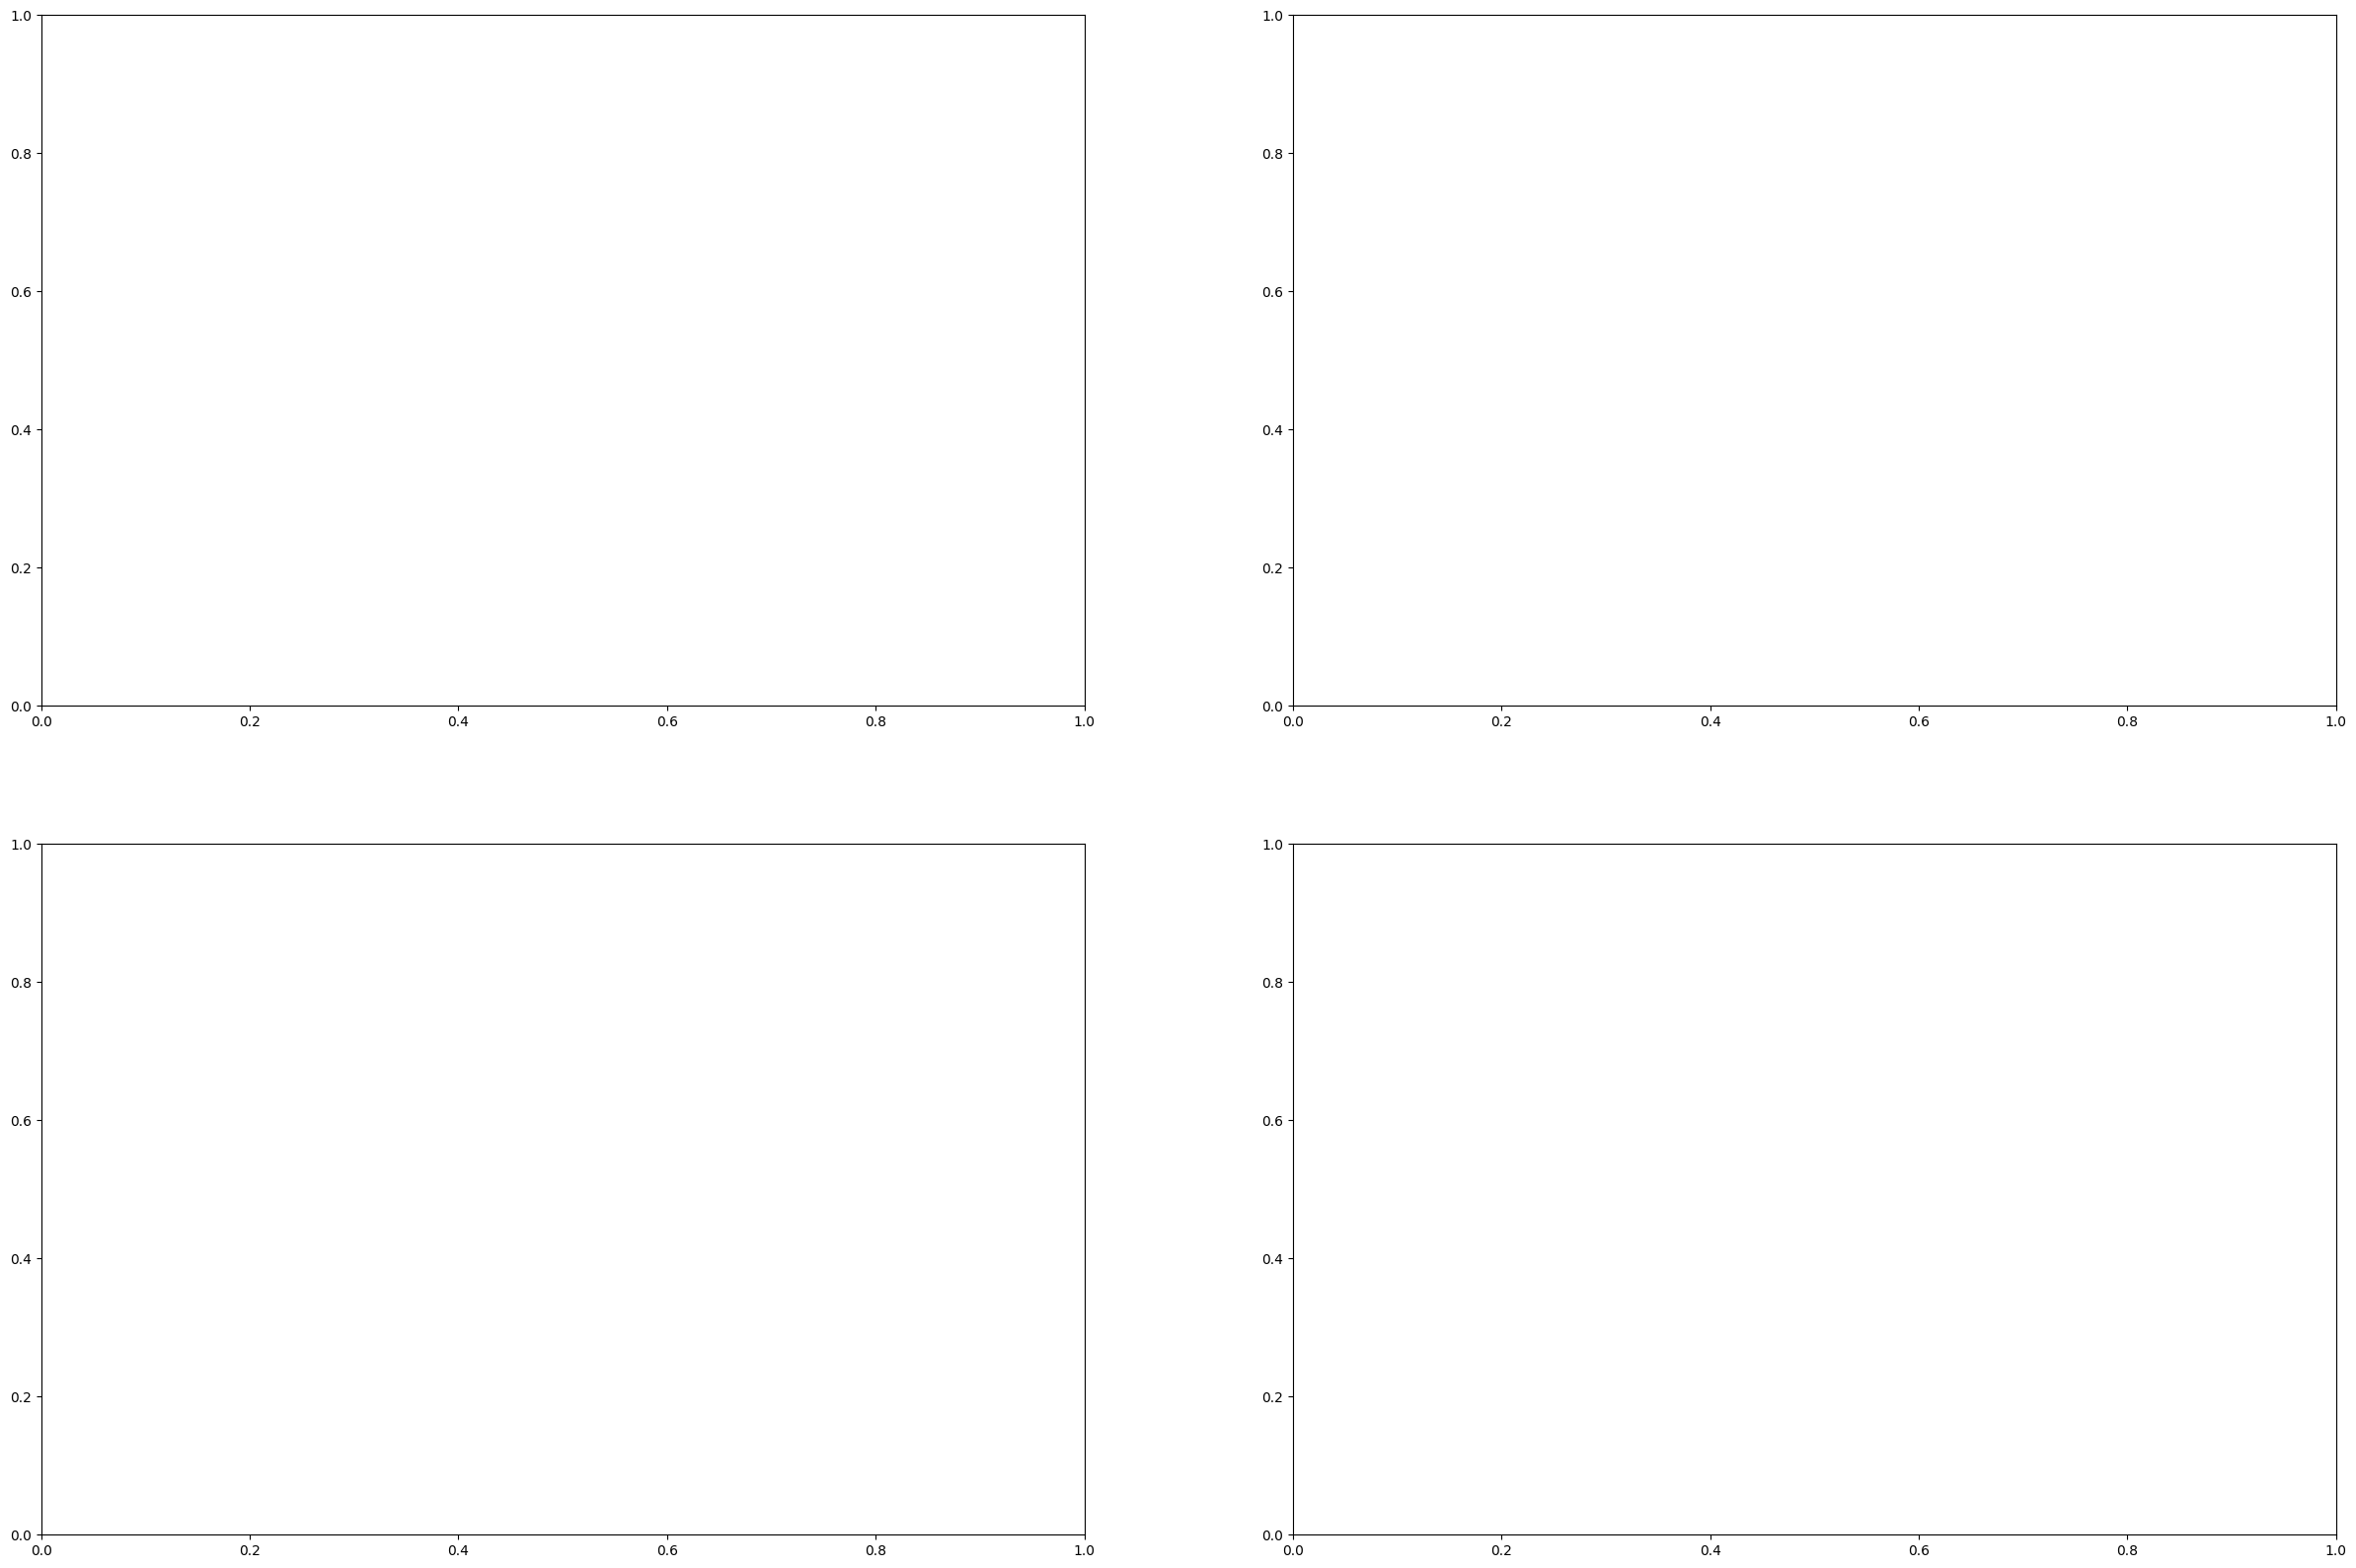

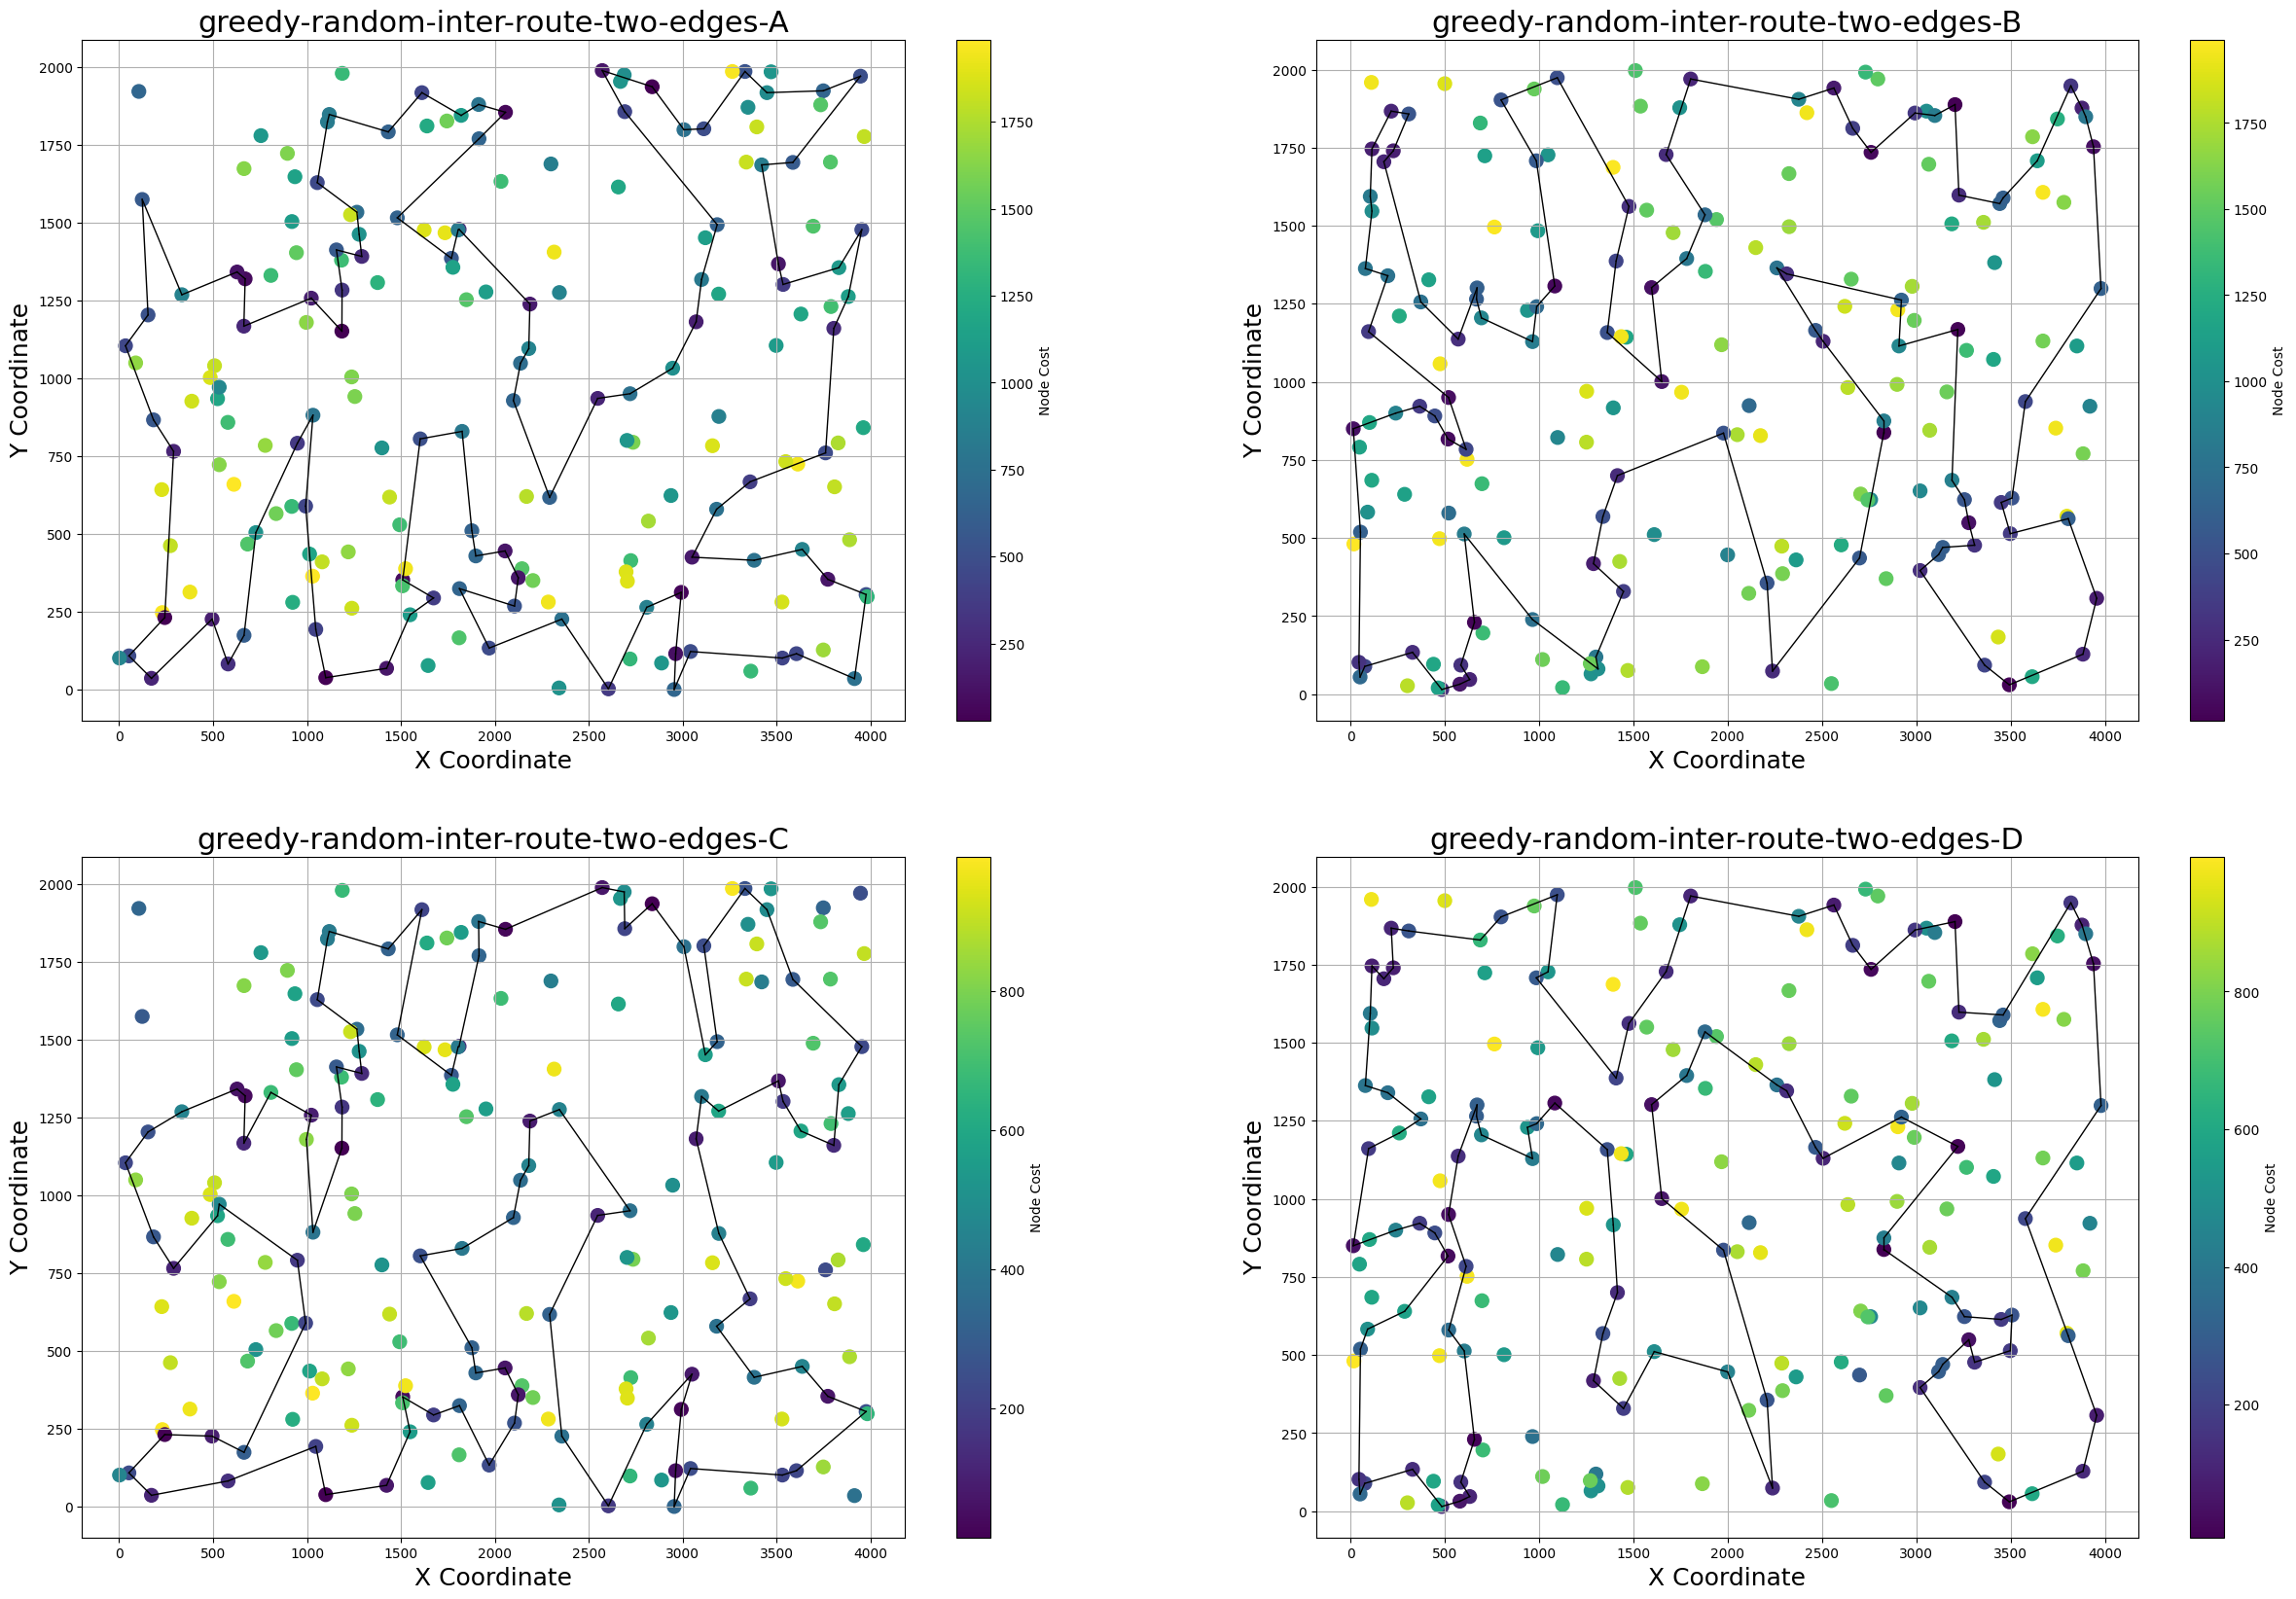

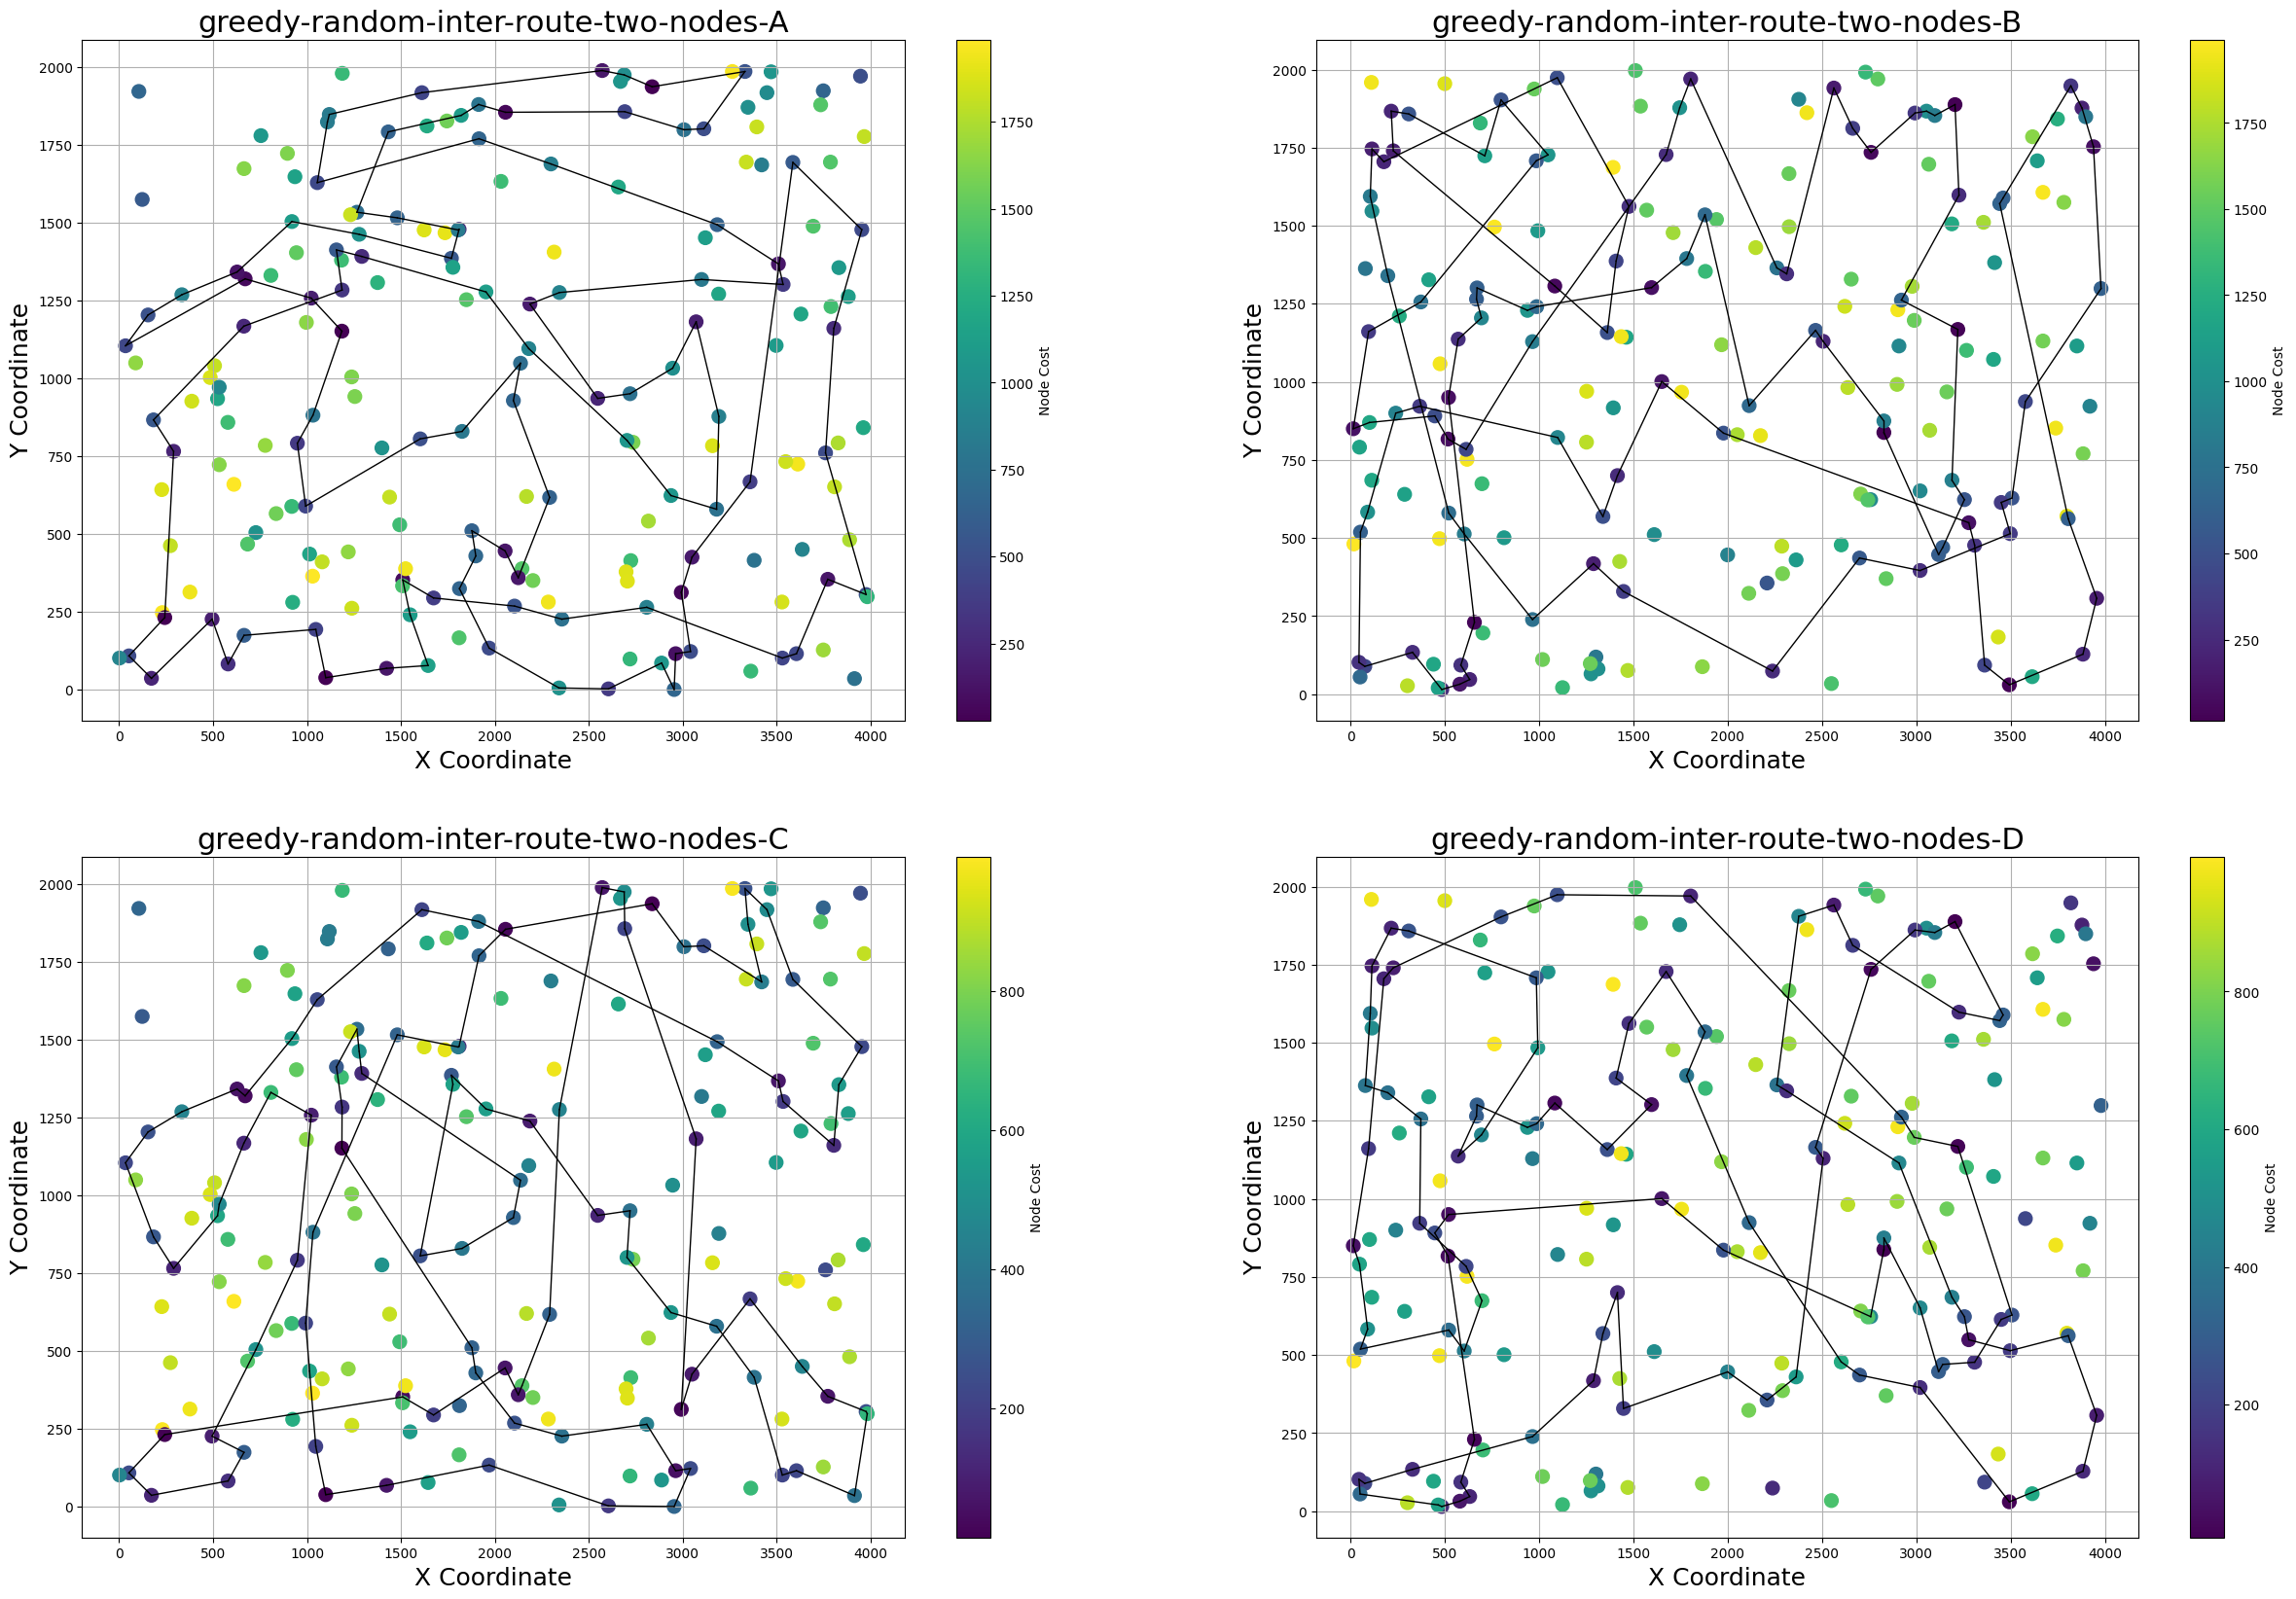

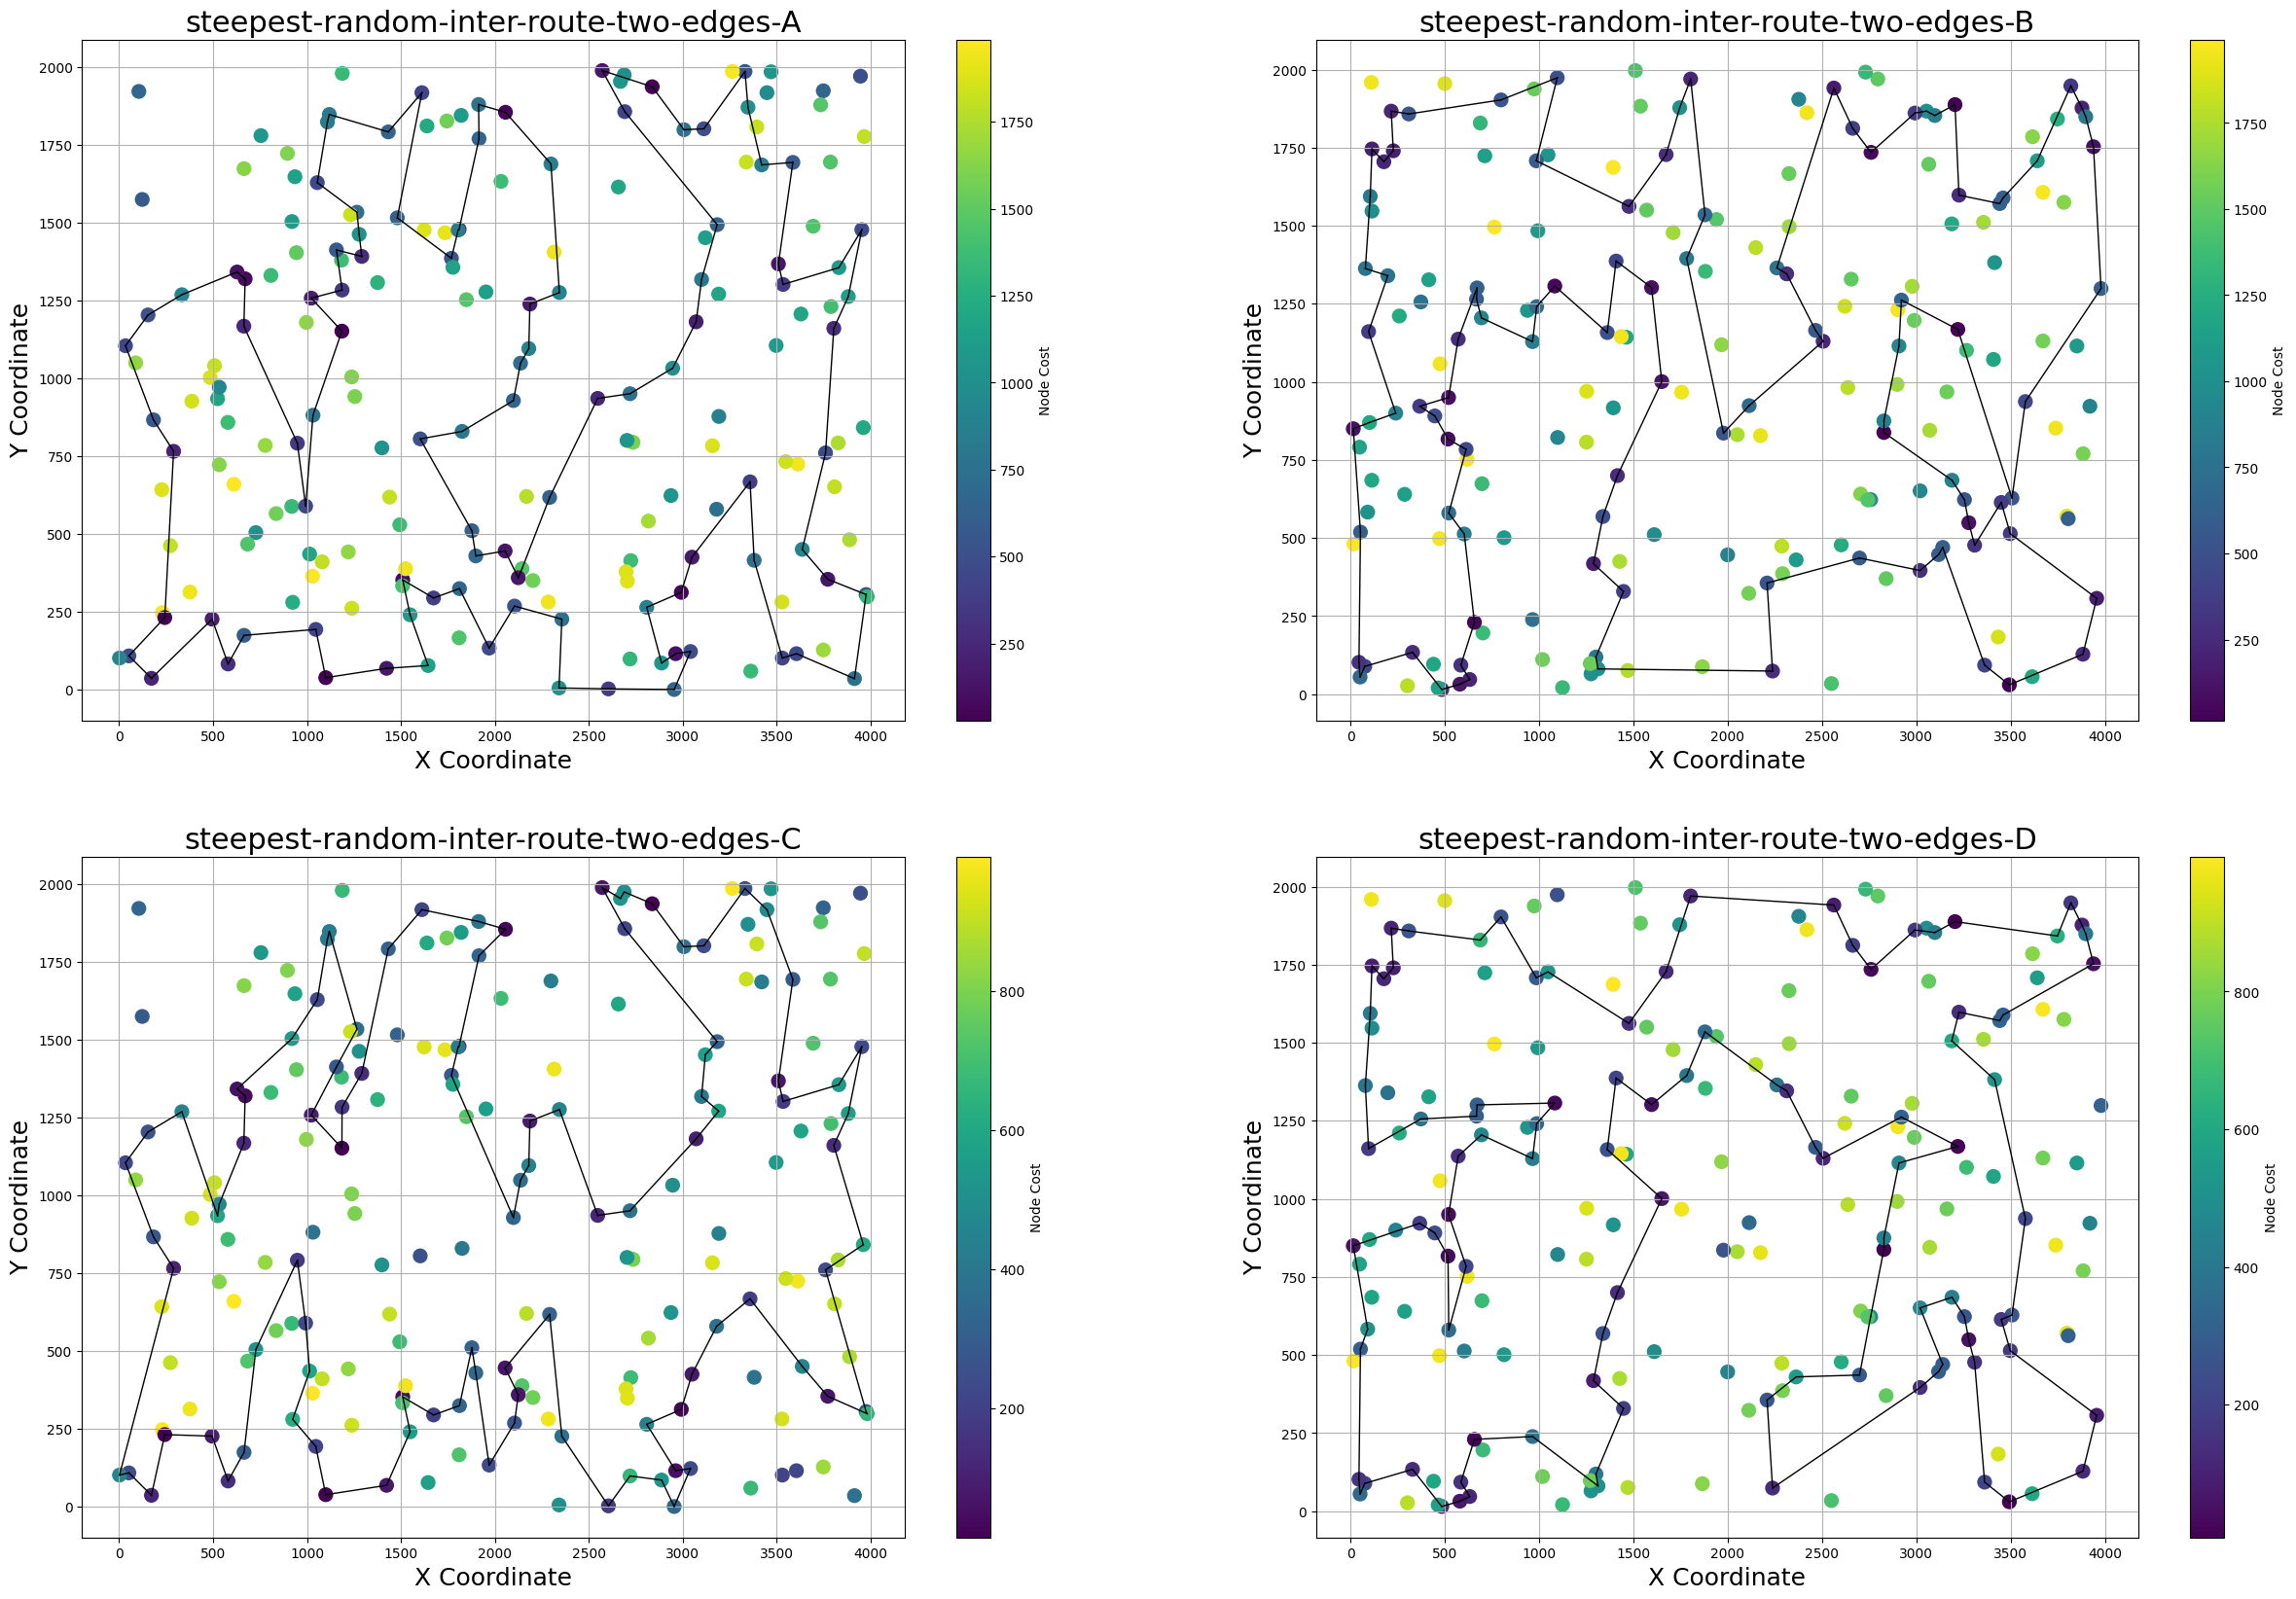

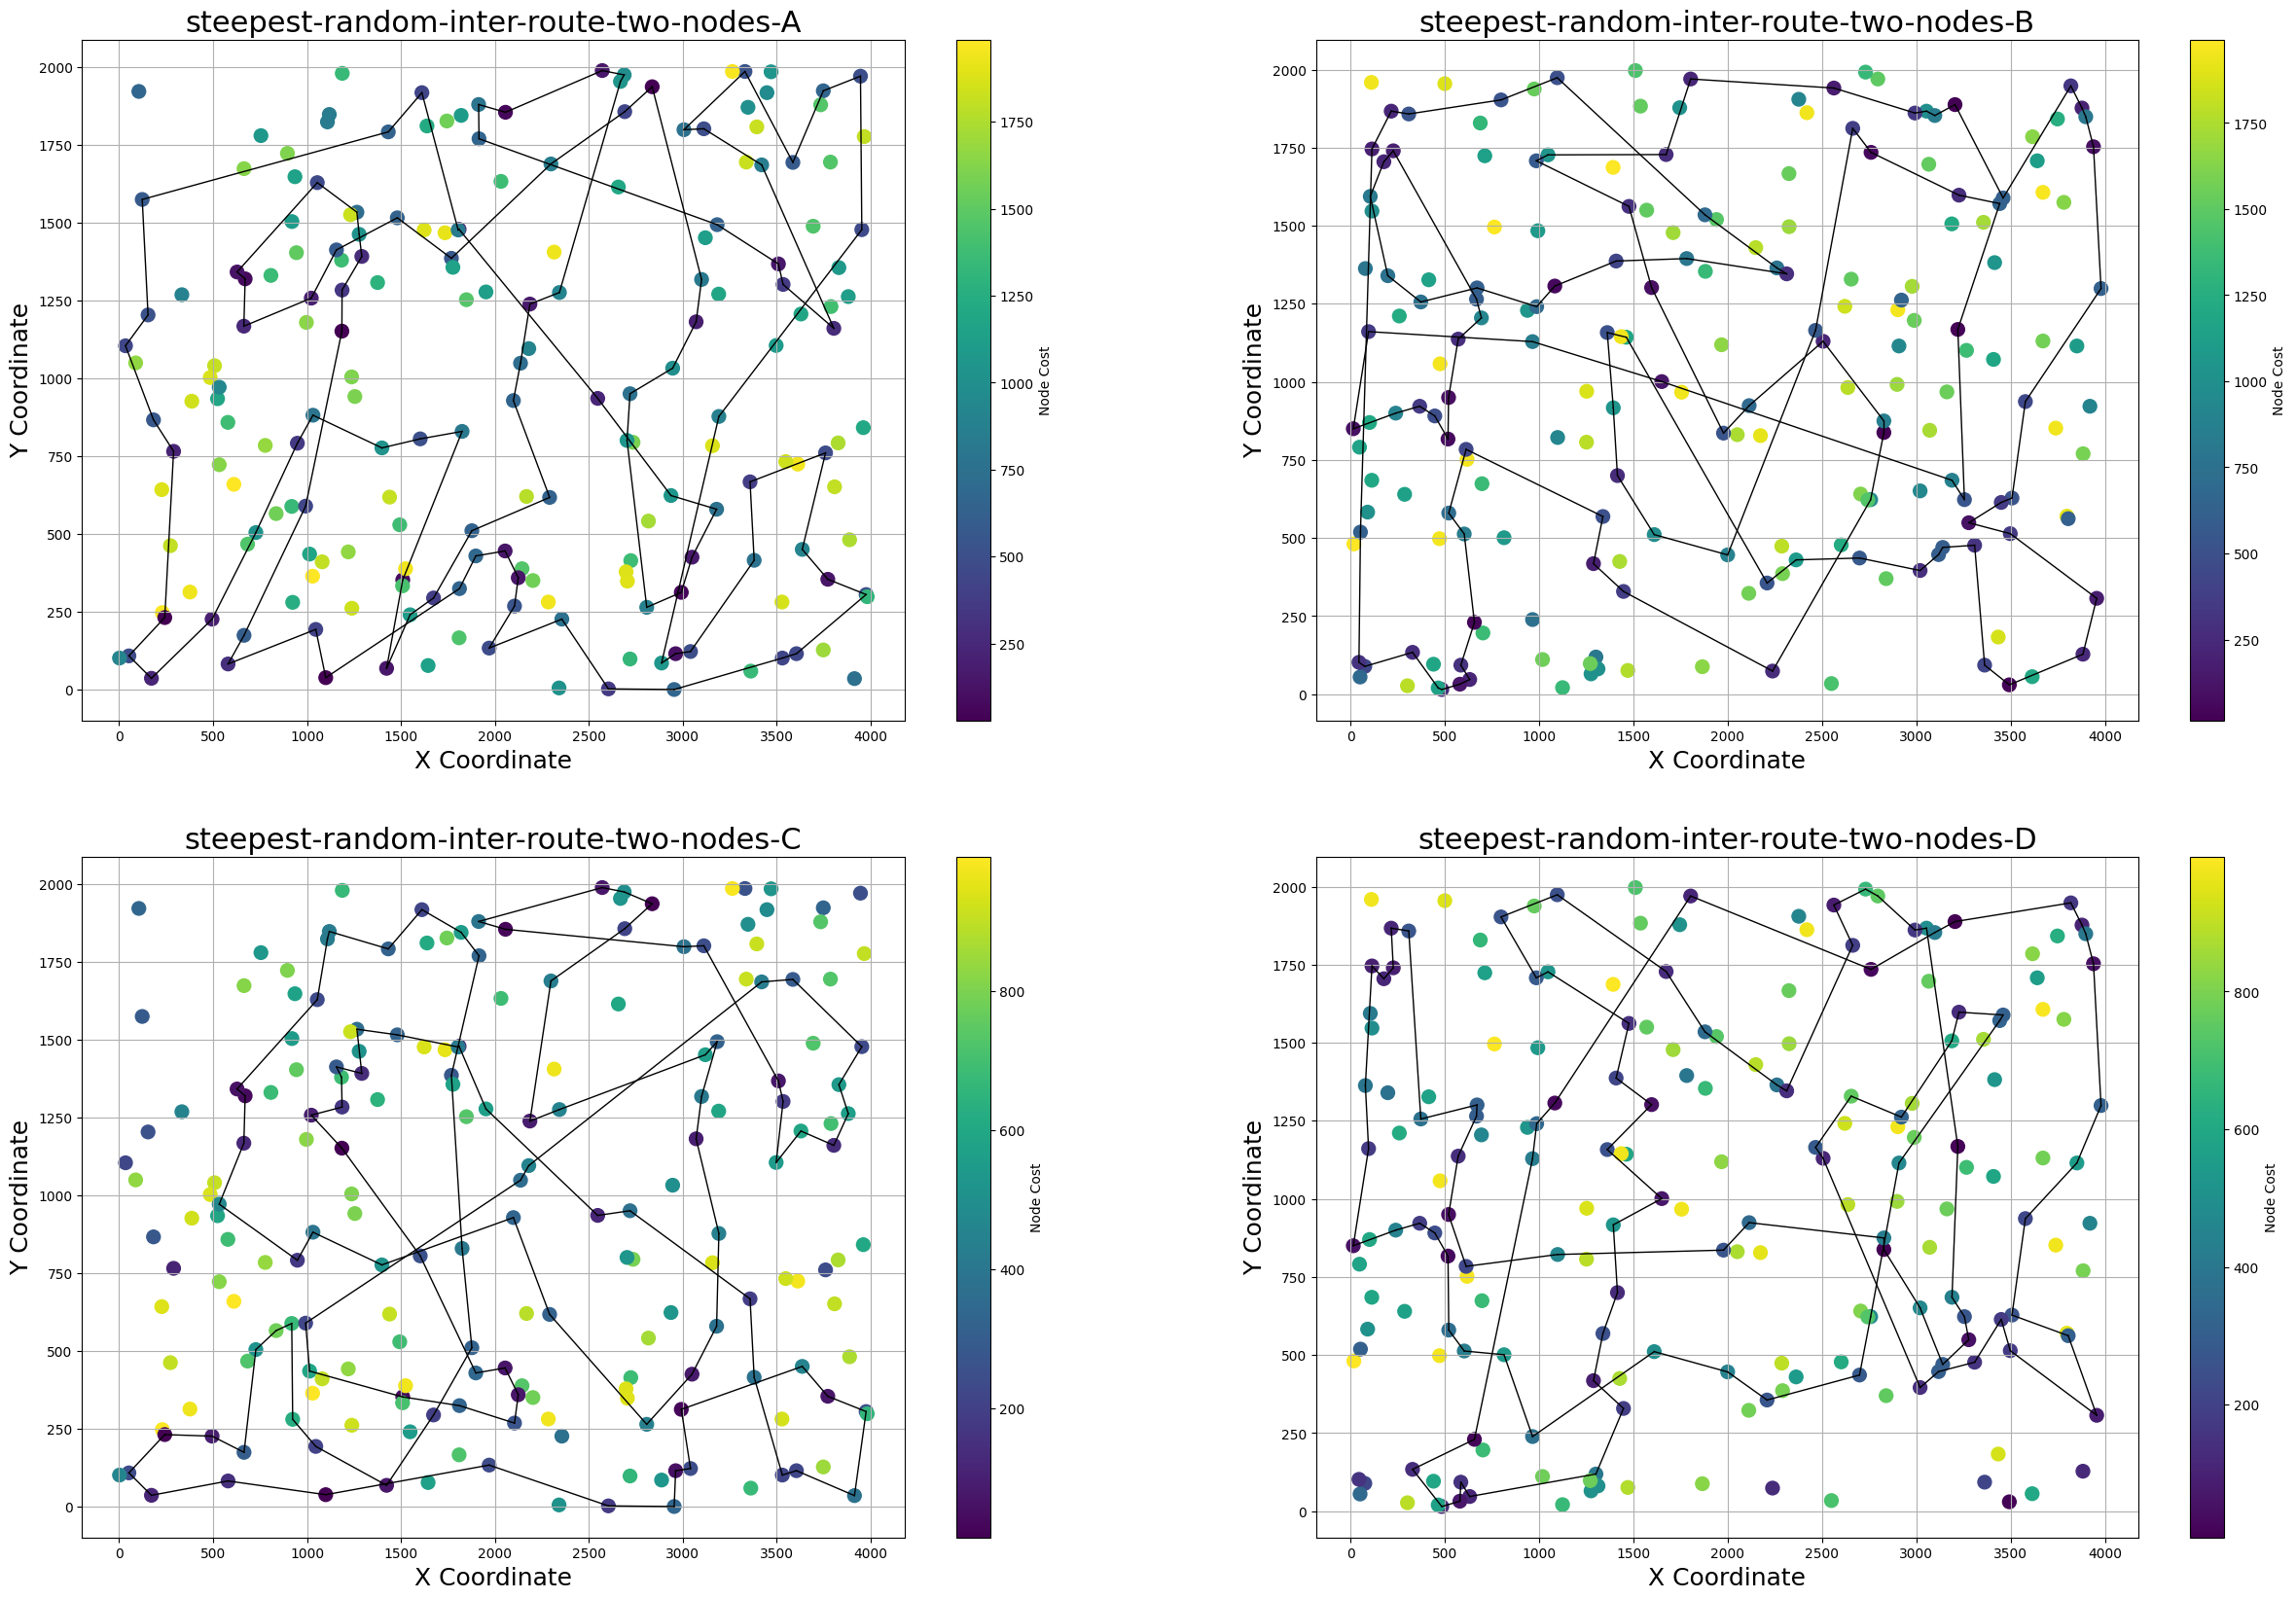

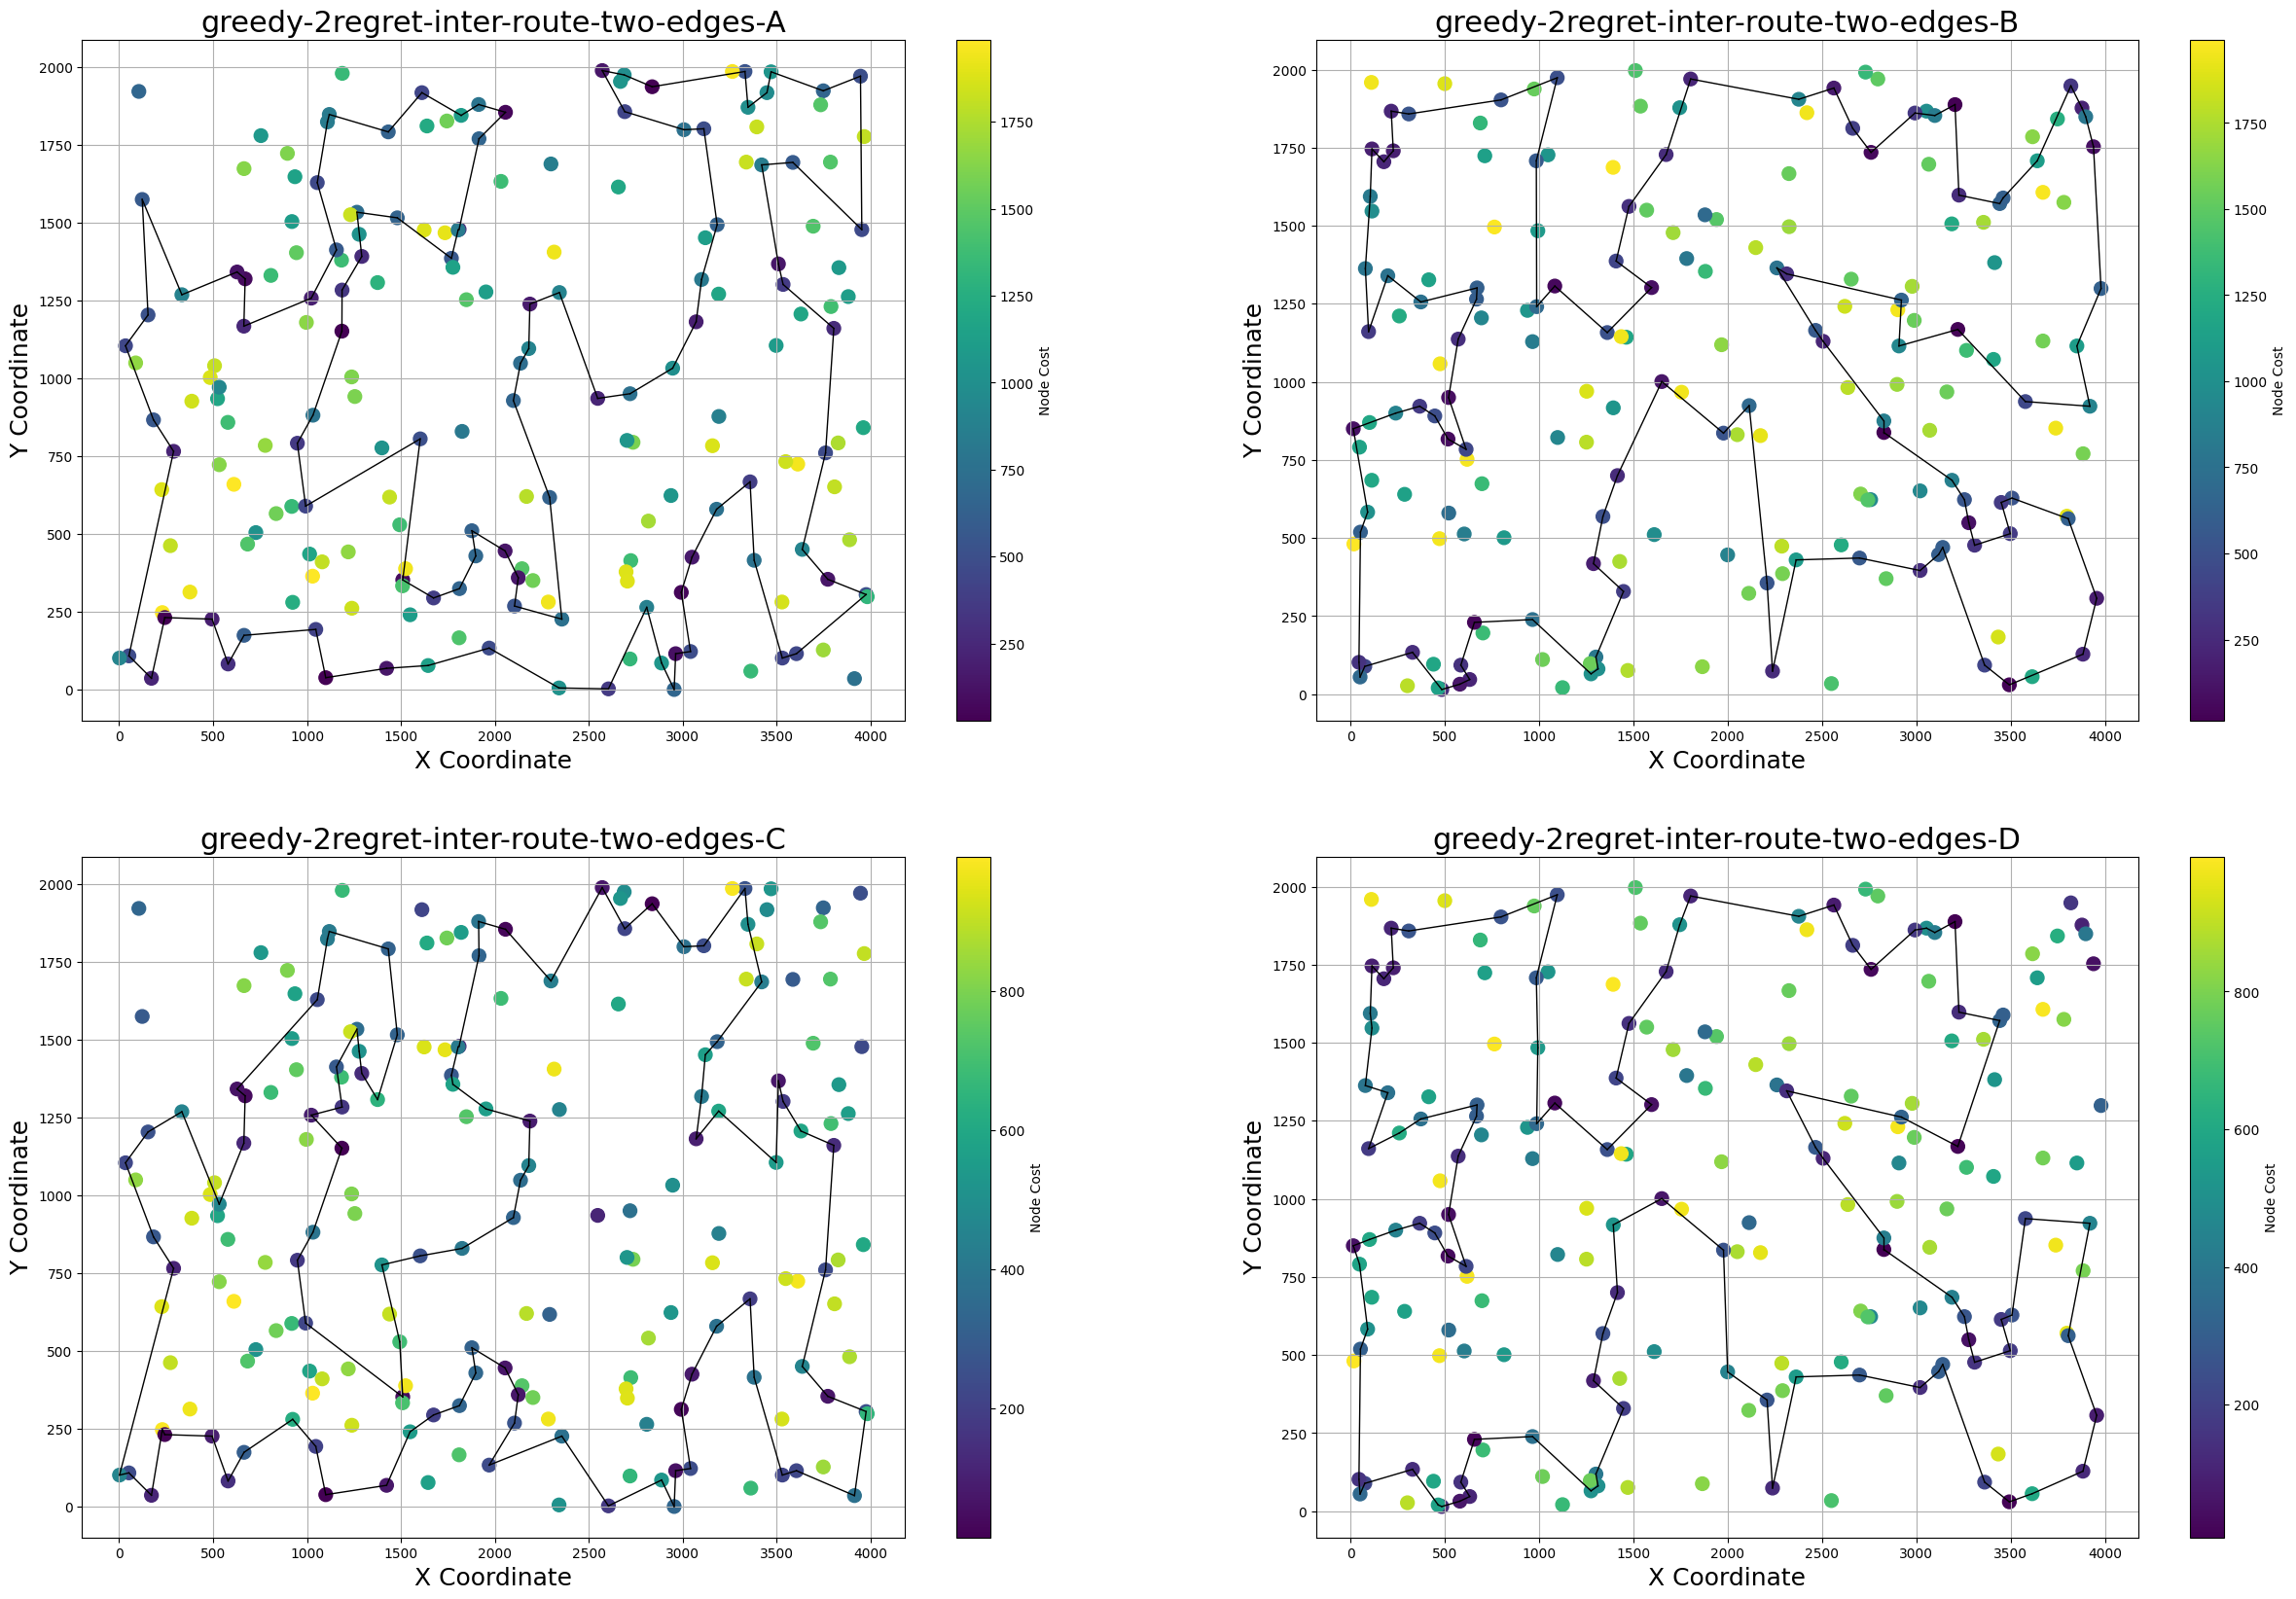

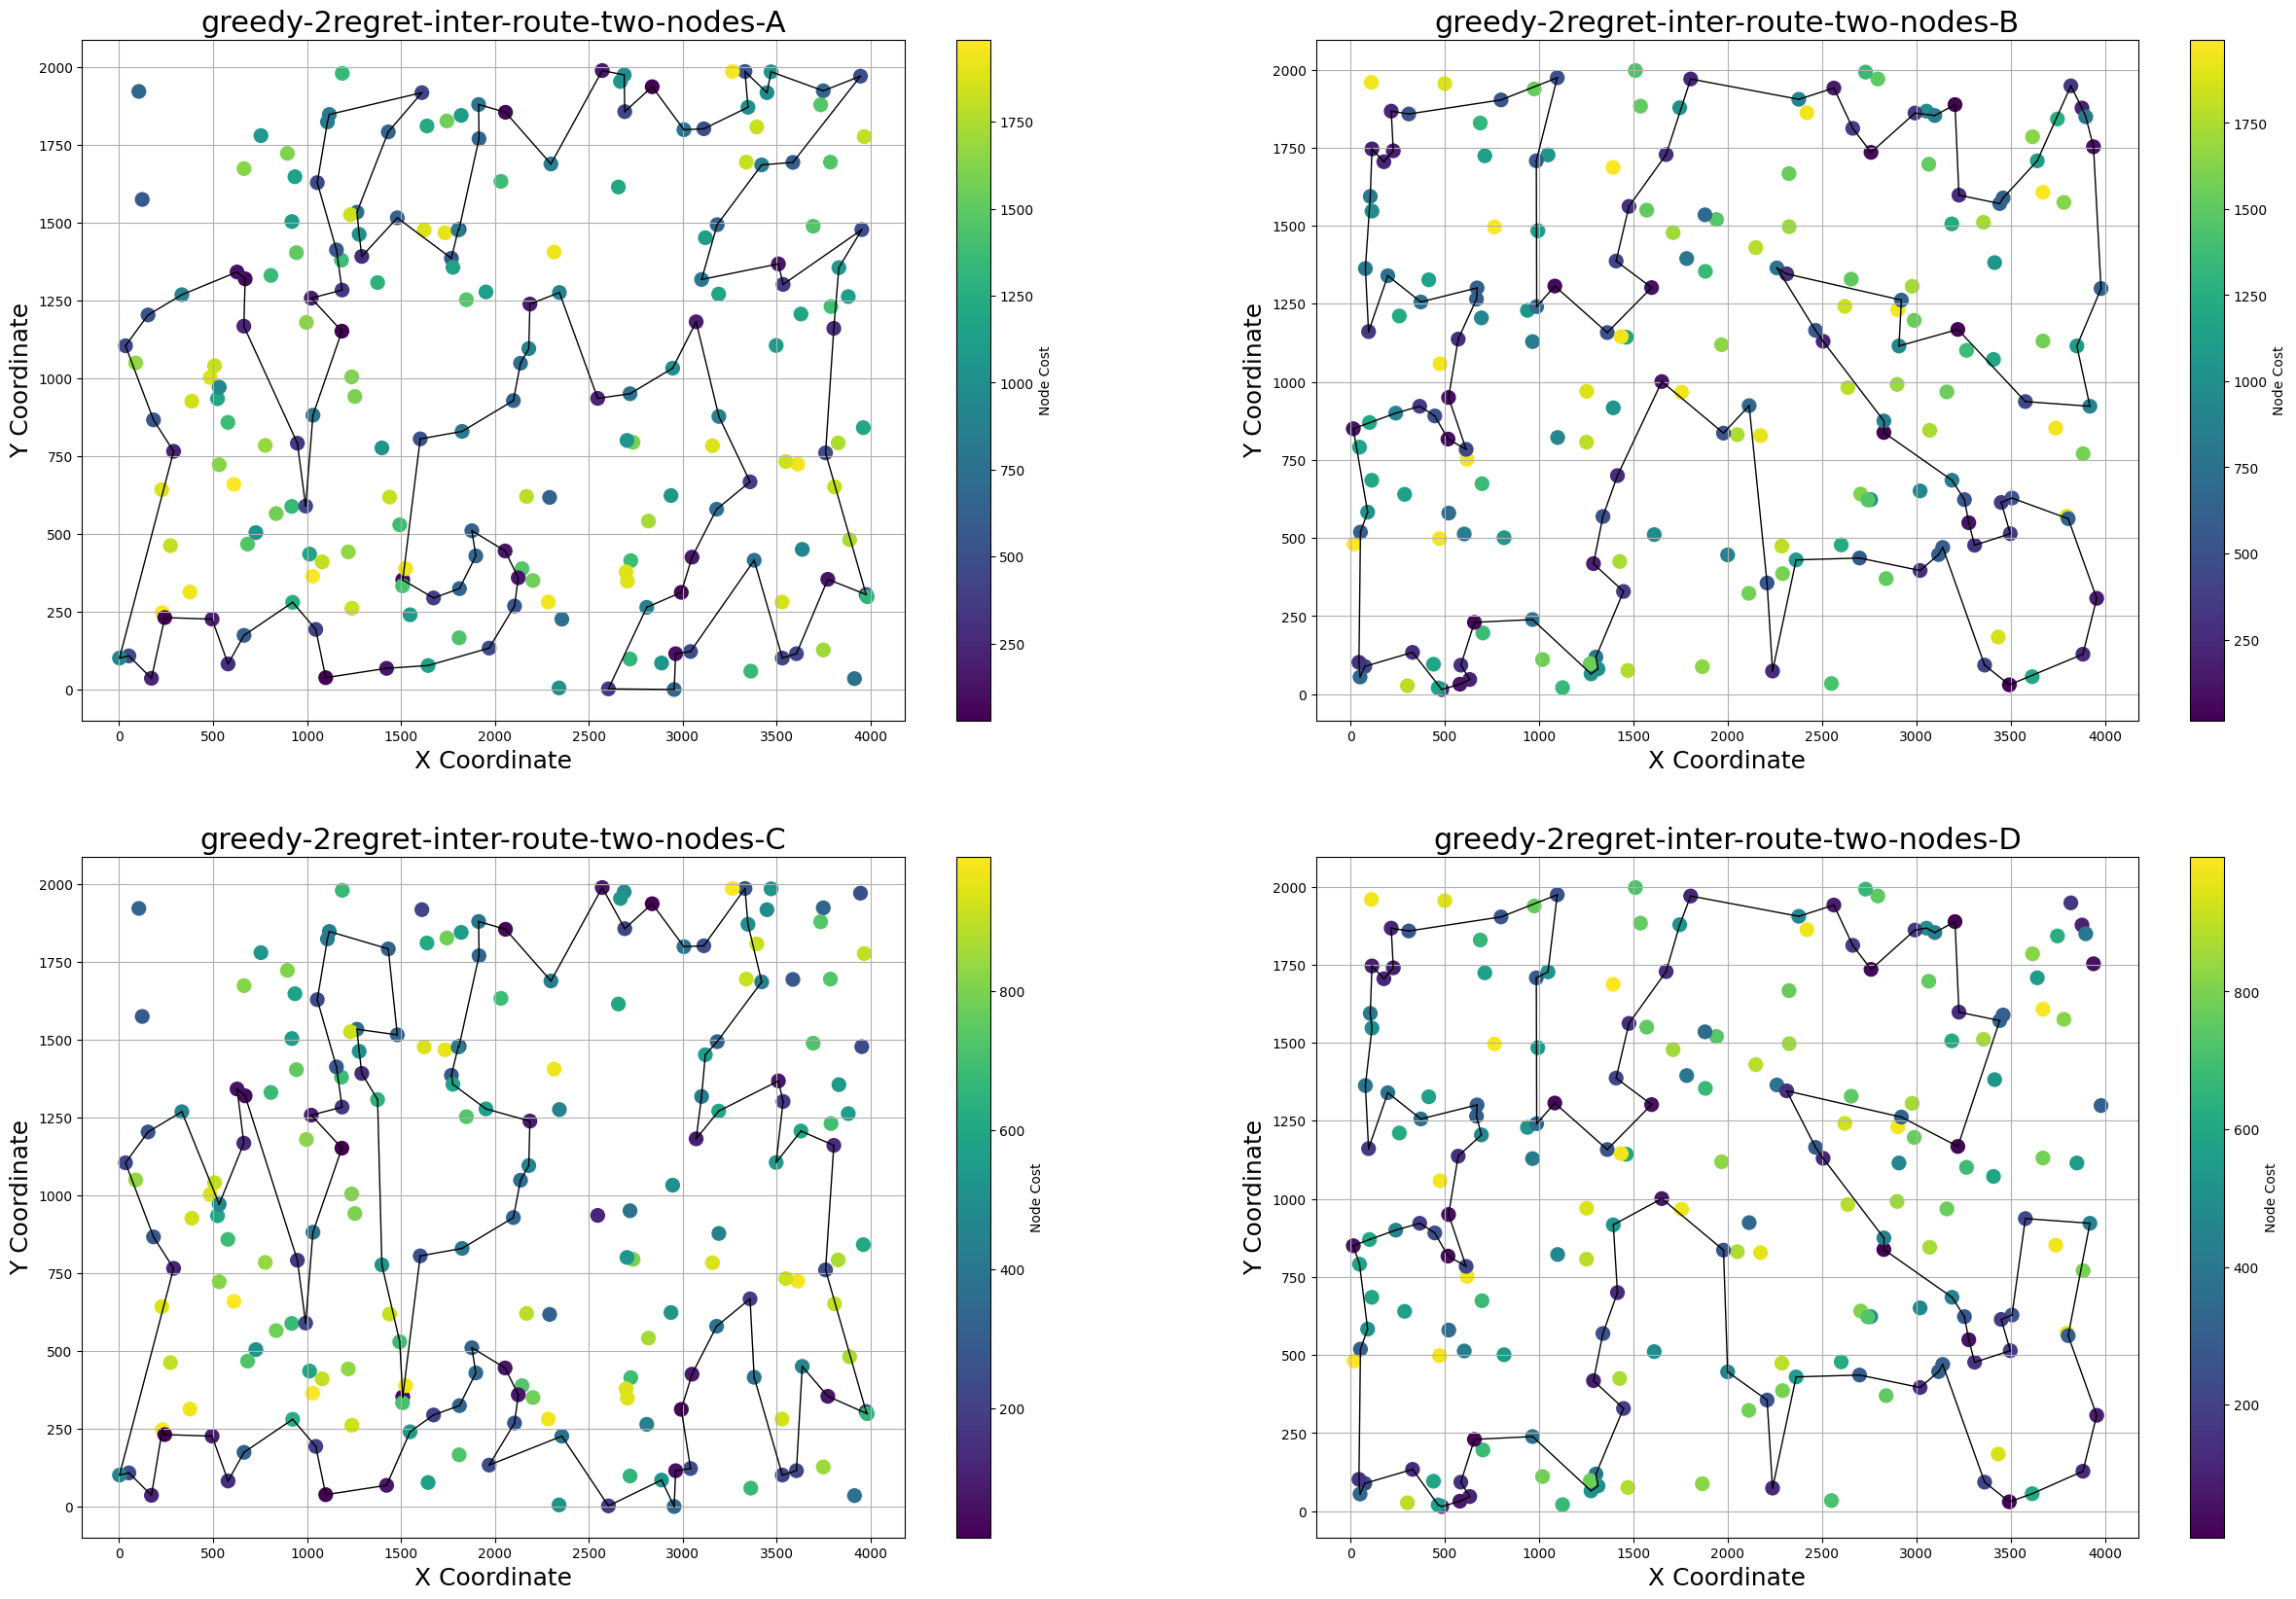

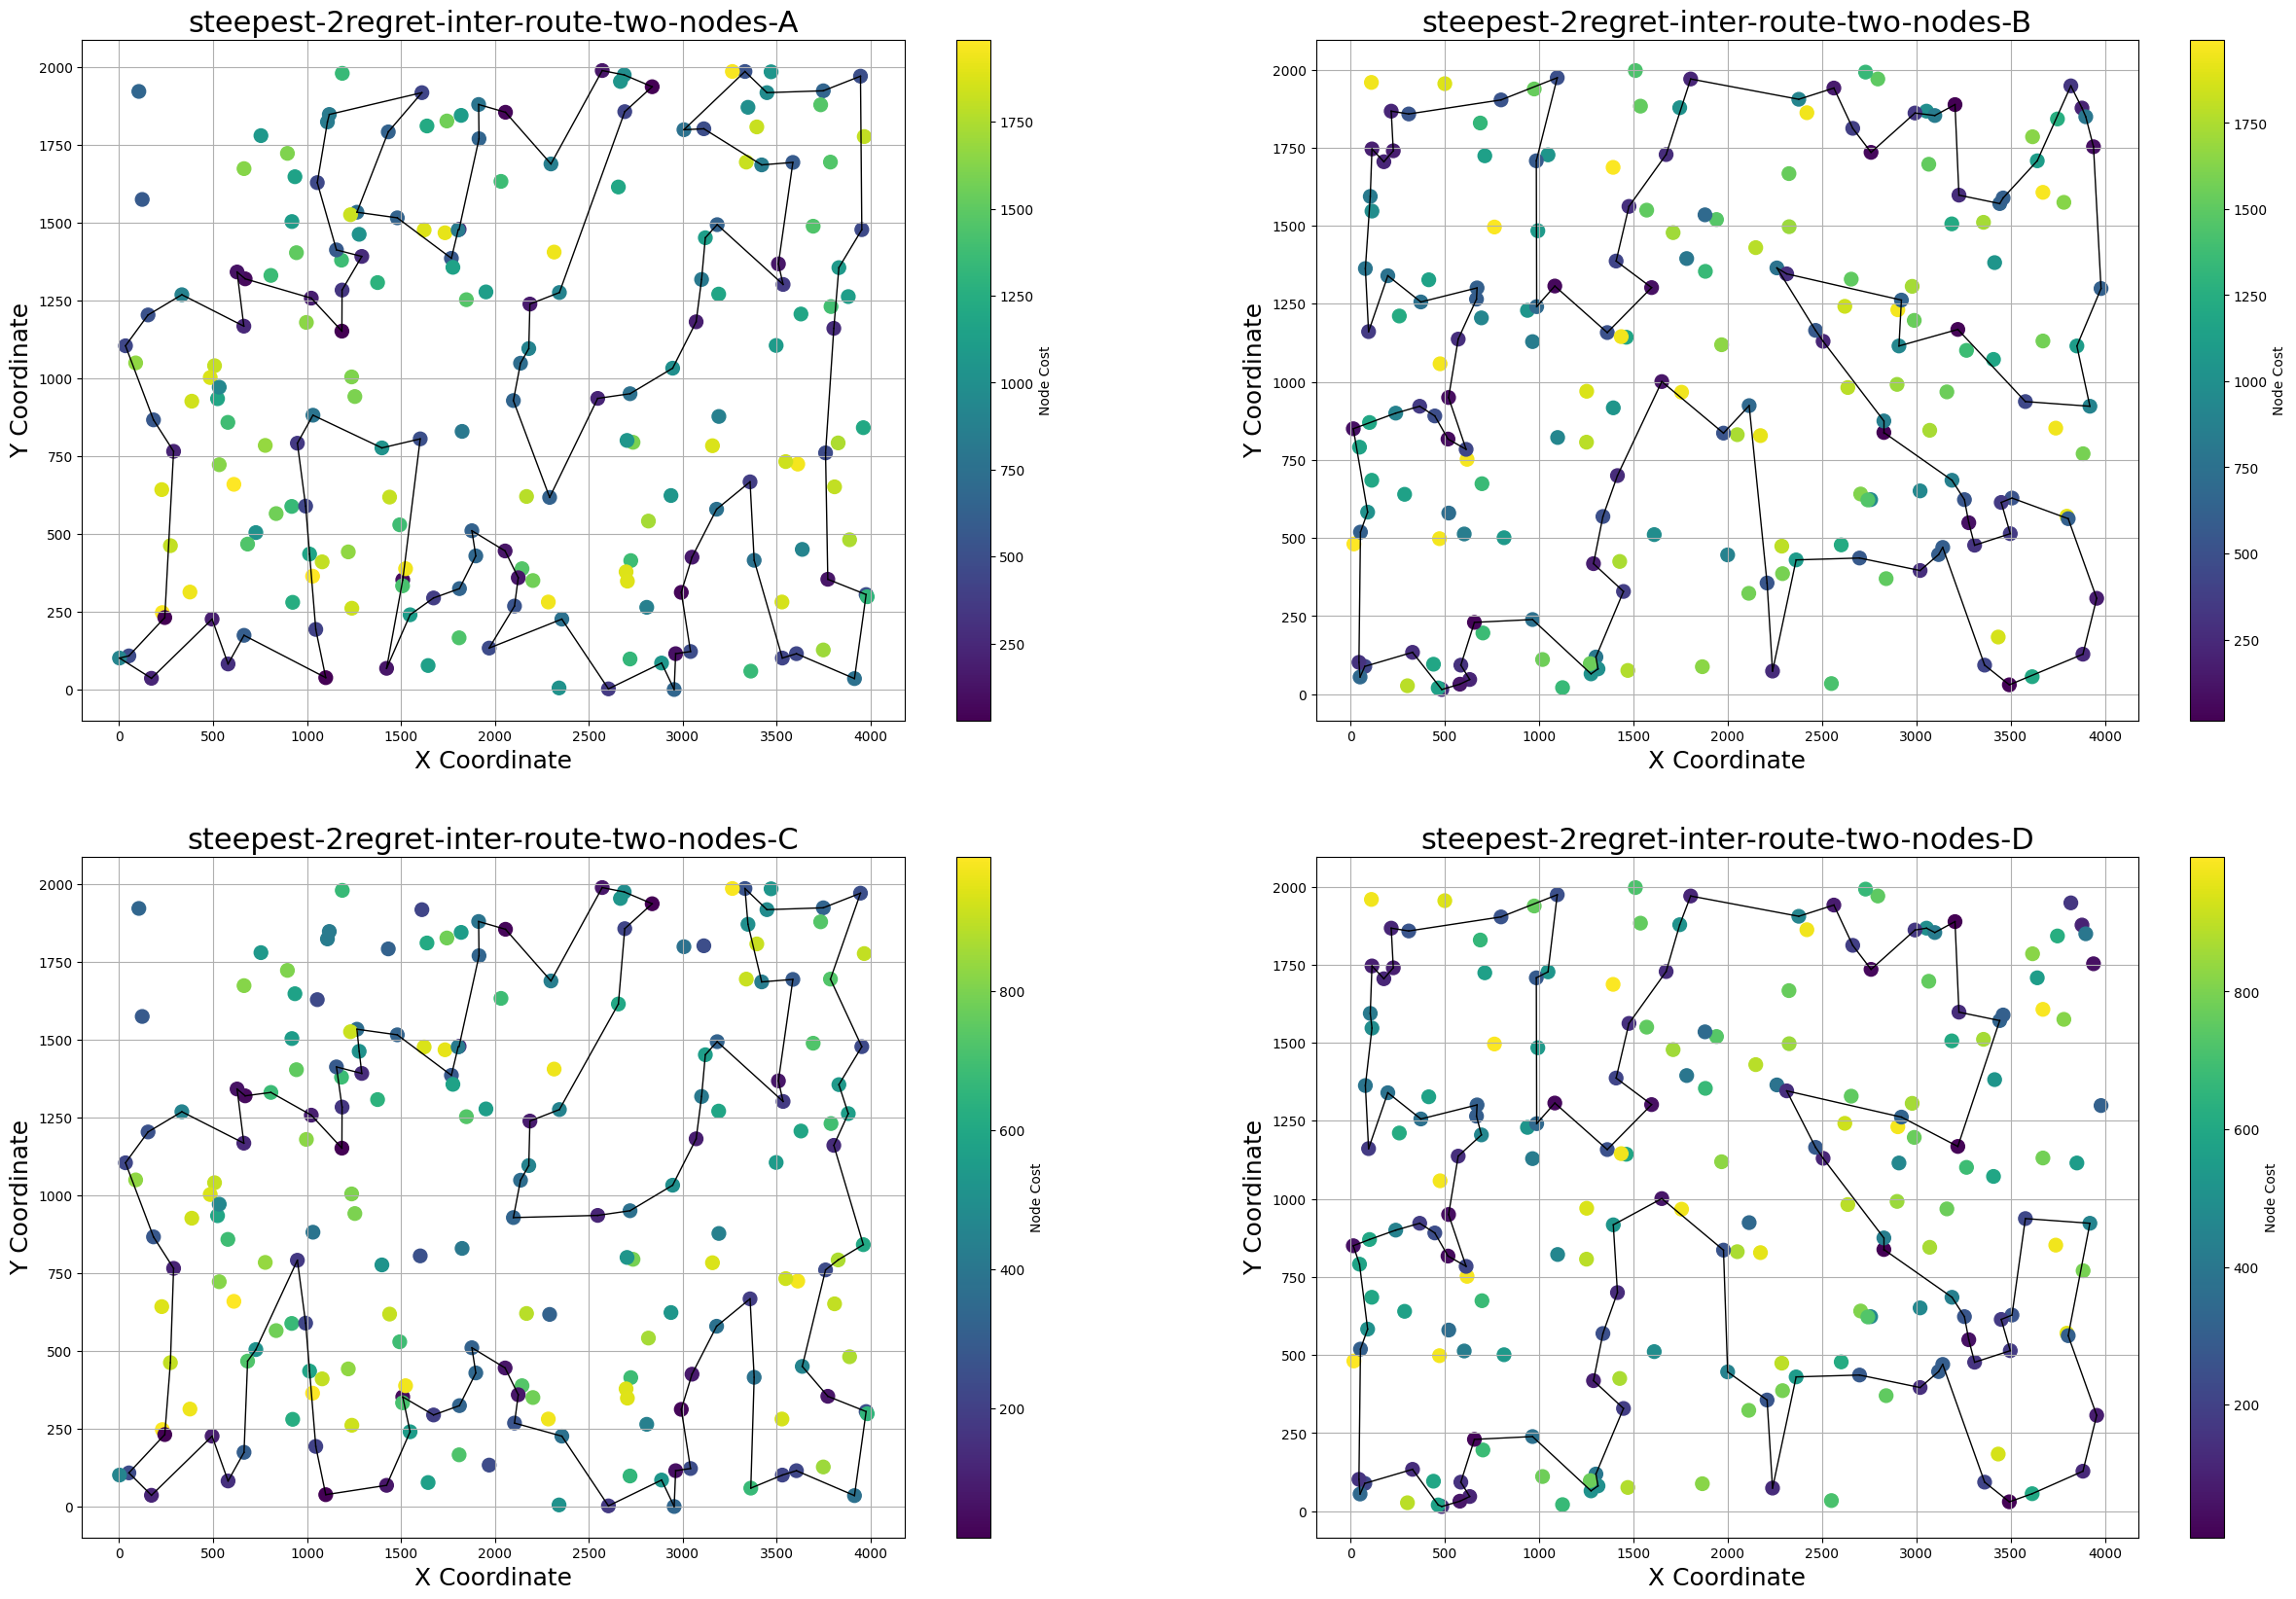

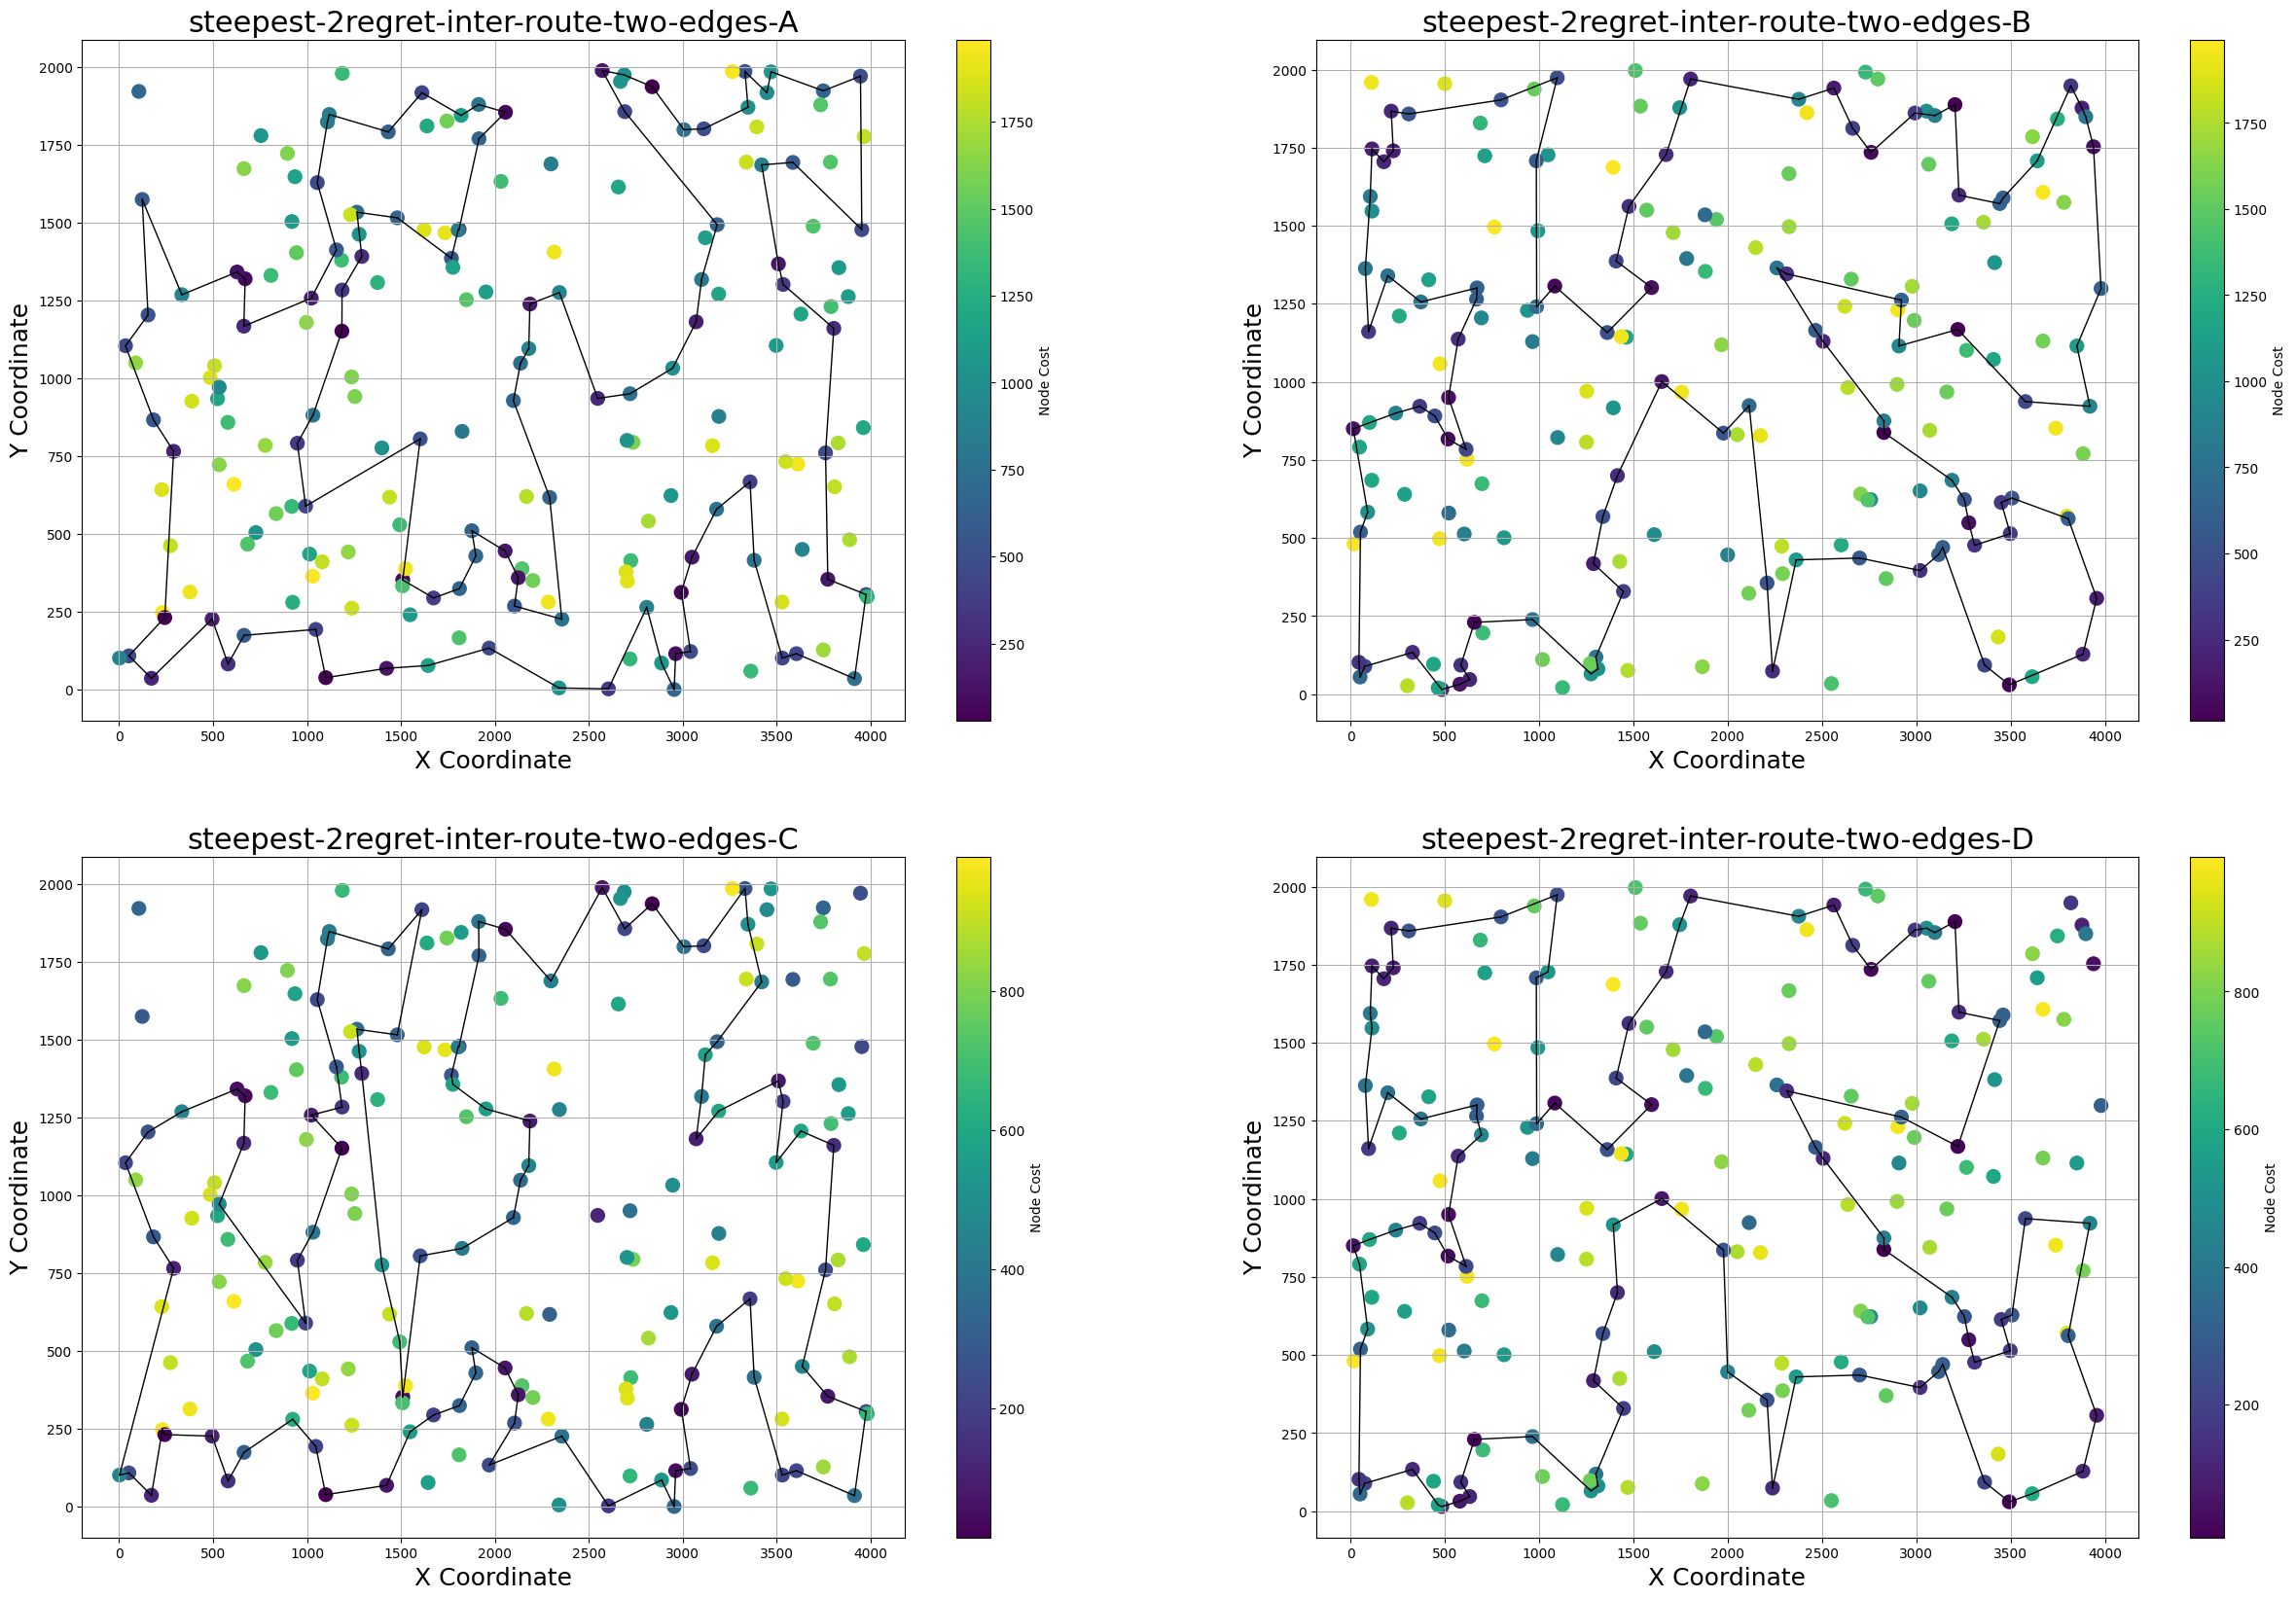

In [291]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy.typing import ArrayLike

def visualize_selected_route(
    selected_nodes_indices: ArrayLike, 
    dataframe: pd.DataFrame,
    title: str,
    ax) -> None:
    """
    Visualize the selected route returned by the algorithm, including the cost of each node represented by a colormap.
    Now uses provided axis object for plotting.
    
    Parameters:
    selected_nodes_indices (list): Indices of the selected nodes in the route.
    dataframe (DataFrame): DataFrame containing 'x', 'y', and 'cost' columns for each node.
    ax (matplotlib.axes.Axes): The axes object where the plot will be drawn.
    """
    x = dataframe["x"].to_numpy()
    y = dataframe["y"].to_numpy()
    costs = dataframe["cost"].to_numpy()

    cmap = plt.cm.get_cmap('viridis')
    norm = plt.Normalize(vmin=min(costs), vmax=max(costs))

    scatter = ax.scatter(x, y, c=costs, cmap=cmap, norm=norm, s=100)
    fig.colorbar(scatter, ax=ax, label='Node Cost')

    for i, node in enumerate(selected_nodes_indices):
        start_node = selected_nodes_indices[i]
        end_node = selected_nodes_indices[(i + 1) % len(selected_nodes_indices)]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'k-', lw=1)

    ax.set_title(title, fontsize=18)
    ax.set_xlabel('X Coordinate', fontsize=18)
    ax.set_ylabel('Y Coordinate', fontsize=18)
    ax.set_title(title, fontsize=22)
    ax.grid(True)

# Example usage:
# Assuming `dataframes_list` is a list of 32 pandas DataFrames
# and `selected_indices_list` is a list of 32 lists of selected node indices.

fig, axs = plt.subplots(2, 2, figsize=(30, 20))  # Adjust figsize as needed
fig.subplots_adjust(hspace=0.2, wspace=0.2)

inst = [title[-1] for title in best_solutions.keys()]
solutions = [solution[0] for solution in best_solutions.values()]
titles = [title for title in best_solutions.keys()]

for i in range(8):
    fig, axs = plt.subplots(2, 2, figsize=(30, 20))  # Adjust figsize as needed
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    for j in range(4):
        idx = i * 4 + j
        if idx < len(solutions):
            row, col = divmod(j, 2)
            visualize_selected_route(
                solutions[idx],
                instances[inst[idx]],
                titles[idx],
                axs[row, col]
            )

    plt.show()  # Display the set of 4 plots


In [282]:
import json
with open("best_solutions.json", "r") as f:
    best_solutions = json.load(f)